# **Supercomputer Job Statistics Analytics**

# **Project Overview:**
The Supercomputer Job Statistics Analytics project aims to uncover valuable insights from the
fine-grained process statistics of jobs executed on Los Alamos National Laboratory’s (LANL) Grizzly
cluster during November 2018. The data, encompassing approximately 51GB of uncompressed,
loosely-JSON-formatted log files, represents a unique opportunity to analyze and understand the
resource utilization patterns and performance characteristics of the Grizzly cluster.

## **Objective:**
The primary goal of this project is to analyze the provided dataset to extract meaningful insights
regarding the cluster’s performance, focusing on memory usage and process statistics. By
employing data science techniques, we aim to identify patterns, anomalies, and potential
optimization opportunities that could enhance the efficiency of supercomputer operations.

## **Data Description:**
The dataset comprises approximately 51 GB of uncompressed, loosely JSON-formatted log files collected from the Grizzly cluster during November 2018. These logs were generated as part of LANL’s system monitoring efforts and are publicly released under LA-UR-18-31147. The data compresses to about 5 GB and is categorized into two primary types:

**Memory Information**
* Content: Detailed statistics on memory usage across various jobs and nodes
within the cluster.
* Metrics Included: Total memory consumption, free memory, cached memory,
buffer sizes, and swap usage.
* Purpose: Offers insights into how memory resources were allocated, utilized,
and managed during different job executions.

**Procstat Data**
* Content: Process-level statistics captured via the Lightweight Distributed
Metric Service (LDMS).
* Metrics Included: CPU usage, process states, thread counts, and other CPU-
related metrics.
* Limitations:
  * Lacks Memory Usage Values: Memory metrics are absent, hindering
  comprehensive resource utilization analysis.
  * Data Inconsistencies: Some files lack job IDs or contain incomplete data,
  complicating the correlation with memory information and other datasets.

## **Data Loading**
* Splitting and Conversion: The large JSON files were split into smaller,
manageable chunks. A custom parser was developed to extract relevant fields
and convert the data into structured CSV format.
* Data Consolidation: Individual CSV files were consolidated into a master
dataset, indexed, and stored in a database to facilitate efficient querying and
analysis.
* Tools Used: Data processing and analysis were conducted using Python
libraries such as Pandas, NumPy, and Dask for handling large datasets.




```
**Split Json File**
f = 'grizzly.procstat.guest_nov2018'


with open(f, 'r') as content_file:
    content = content_file.read()

# this is our file rename
f = 'procstat_guest/grizzly.procstat.guest_nov2018'

a = content.split("\n[")

for i in range(0, len(a) - 1):
    # we have a problem with lacking prepended '['s because of the split above
    if a[i][0] != '[':
        a[i] = '[' + a[i]
    fnew = f + "." + str(i + 1)
    with open(fnew, 'w') as text_file:
        text_file.write(a[i])

```








```
**#Converting splitted json files to csv**

import json
import csv
import os

# Directory containing your files
input_folder = 'procstat_guest'
output_folder = 'procstat_guest_csv'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all files in the input folder that match the pattern
for filename in os.listdir(input_folder):
    if filename.startswith('grizzly.procstat.guest_nov2018.'):
        input_file = os.path.join(input_folder, filename)
        output_file = os.path.join(output_folder, filename + '.csv')

        # Open the file and load the data as JSON
        with open(input_file, 'r') as infile:
            data = json.load(infile)

        # Open a CSV file for writing
        with open(output_file, 'w', newline='') as csvfile:
            # Define the CSV writer
            csvwriter = csv.writer(csvfile)

            # Write the header
            header = ['host', 'jobid', 'timestamp', 'value']
            csvwriter.writerow(header)

            # Loop through each entry in the data
            for entry in data:
                metric = entry.get('metric', '')
                tags = entry.get('tags', {})
                host = tags.get('host', '')
                jobid = tags.get('jobid', '')
                dps = entry.get('dps', {})

                # Write each timestamp and its corresponding value
                for timestamp, value in dps.items():
                    csvwriter.writerow([host, jobid, timestamp, value])

        print("Conversion complete for {}. CSV file saved at: {}".format(filename, output_file))

print("All files have been processed.")
```





```
**Merge CSV**

import os
import pandas as pd

# Directory containing the CSV files
input_folder = 'meminfo_active_csv'
output_file = 'combined_grizzly_meminfo_active.csv'

# List to hold data from all CSV files
csv_list = []

# Counter for the number of processed files
file_count = 0

# Loop through all files in the input folder that match the pattern
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_folder, filename)
        # Read the CSV file and append to the list
        csv_data = pd.read_csv(file_path)
        csv_list.append(csv_data)
        
        # Increment the file count and break if we have processed 100 files
        file_count += 1
        if file_count >= 100:
            break

# Concatenate all CSV files into one DataFrame
combined_csv = pd.concat(csv_list, ignore_index=True)

# Save the combined CSV to a file
combined_csv.to_csv(os.path.join(input_folder, output_file), index=False)

print(f"First 100 CSV files have been combined into: {output_file}")
```



## **Data Cleaning and Structuring**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'combined_grizzly_meminfo_active.csv'
df = pd.read_csv(file_path)

output_folder = 'full_dataset_analysis_plots'  # Specify folder name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Step 1: Remove rows where 'jobid' equals 0
df_cleaned = df[df['jobid'] != 0].copy()

# Step 2: Convert timestamp to datetime and calculate job duration
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'], unit='s')


## **Exploratory Data Analysis (EDA)**

### Statistical Summaries


In [2]:
# Statistical summaries for memory usage
memory_stats = df_cleaned['value'].describe()
print("Memory Usage Statistical Summary:")
print(memory_stats)

# Additional calculations
memory_variance = df_cleaned['value'].var()
print("\nMemory Usage Variance:", memory_variance)

Memory Usage Statistical Summary:
count    1.302710e+08
mean     1.595051e+07
std      1.959913e+07
min      6.690320e+05
25%      3.799260e+06
50%      9.200812e+06
75%      1.677782e+07
max      1.271561e+08
Name: value, dtype: float64

Memory Usage Variance: 384125721676019.4


### Distribution Analysis

Histogram of Memory Usage:

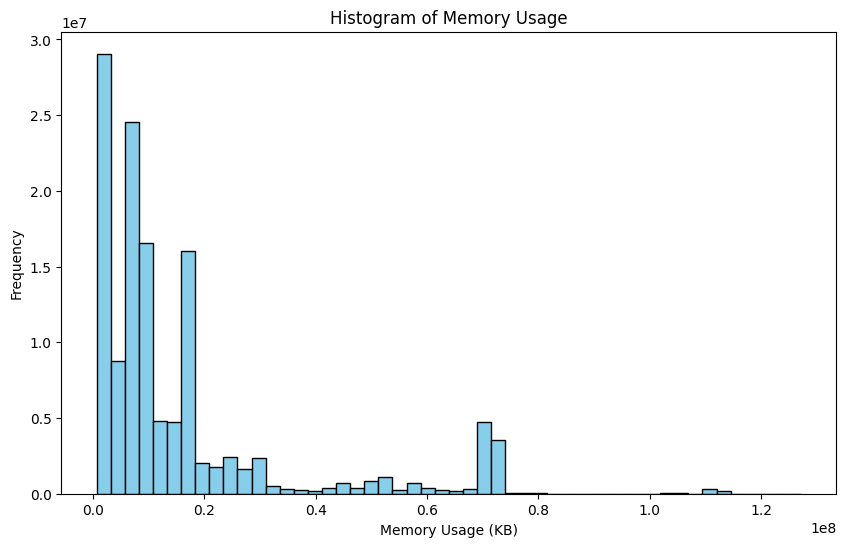

In [3]:
plt.figure(figsize=(10,6))
plt.hist(df_cleaned['value'], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Memory Usage")
plt.xlabel("Memory Usage (KB)")
plt.ylabel("Frequency")
file_path = os.path.join(output_folder, 'histogram_memory_usage.png')
plt.savefig(file_path, format='png')
plt.show()

Boxplot of Memory Usage:

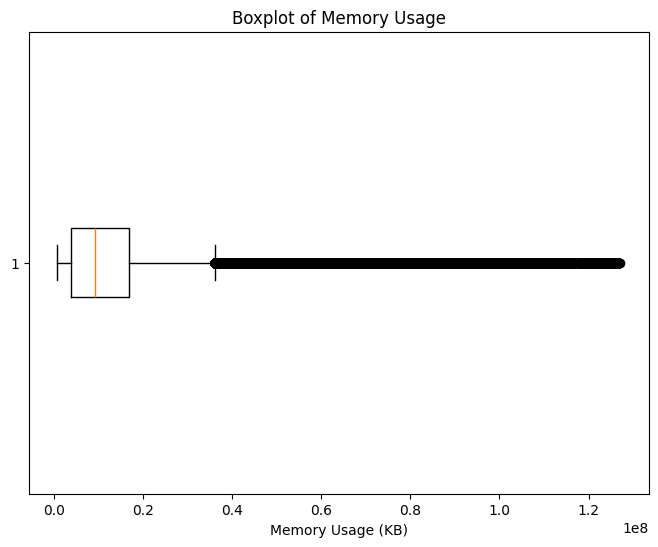

In [4]:
plt.figure(figsize=(8,6))
plt.boxplot(df_cleaned['value'], vert=False)
plt.title("Boxplot of Memory Usage")
plt.xlabel("Memory Usage (KB)")
file_path = os.path.join(output_folder, 'boxplot_memory_usage.png')
plt.savefig(file_path, format='png')
plt.show()

### Time Series Analysis

Plotting memory usage over time for a specific job:

In [5]:
# Set the timestamp column as the index
df_cleaned.set_index('timestamp', inplace=True)

C:\Users\kruth\AppData\Local\Temp\ipykernel_30028\3186641180.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\kruth\AppData\Local\Temp\ipykernel_30028\3186641180.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_path, format='png')
C:\Users\kruth\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


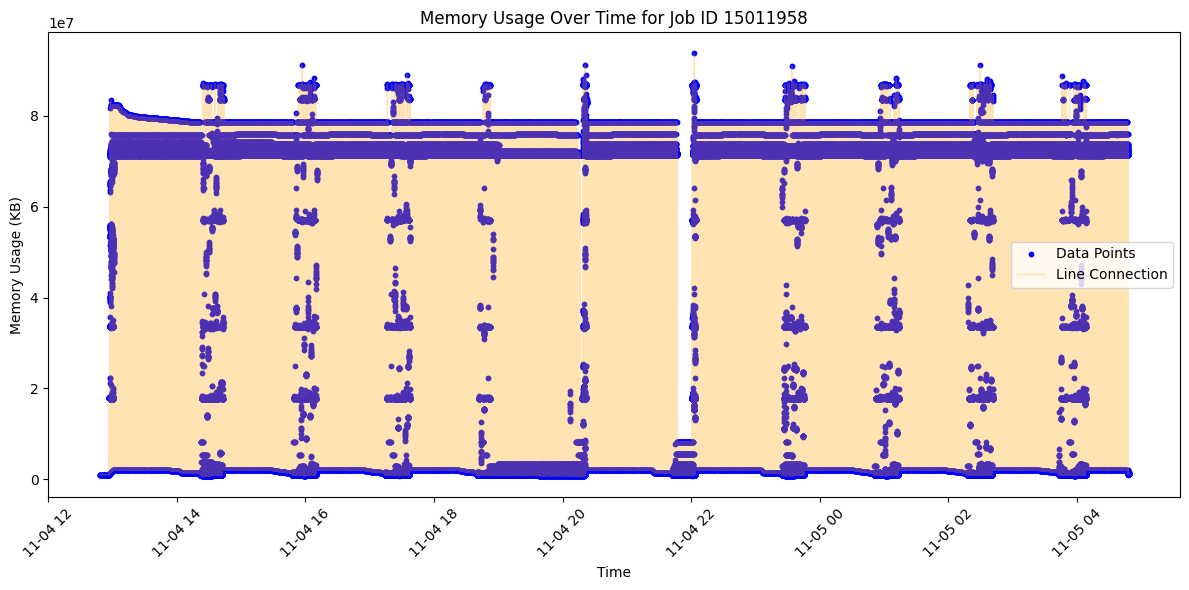

In [6]:


# Select the first job ID or specify a job ID
jobid_to_analyze = df_cleaned['jobid'].unique()[0]
df_job = df_cleaned[df_cleaned['jobid'] == jobid_to_analyze]

# Sort the data by the timestamp to ensure lines are drawn left-to-right
df_job = df_job.sort_index()

# Plot memory usage over time for the selected job
plt.figure(figsize=(12, 6))

# First, plot points only
plt.scatter(df_job.index, df_job['value'], label='Data Points', color='blue', s=10)

# Then, draw lines from left to right with transparency
plt.plot(df_job.index, df_job['value'], linestyle='-', color='orange', linewidth=1, alpha=0.3, label='Line Connection')

# Improve plot appearance
plt.title(f"Memory Usage Over Time for Job ID {jobid_to_analyze}")
plt.xlabel("Time")
plt.ylabel("Memory Usage (KB)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Save the plot as a PNG file
file_path = os.path.join(output_folder, 'memory_usage_time_jobid_transparent_lines.png')
plt.savefig(file_path, format='png')
plt.show()


Plotting memory usage over time for a specific node (host):

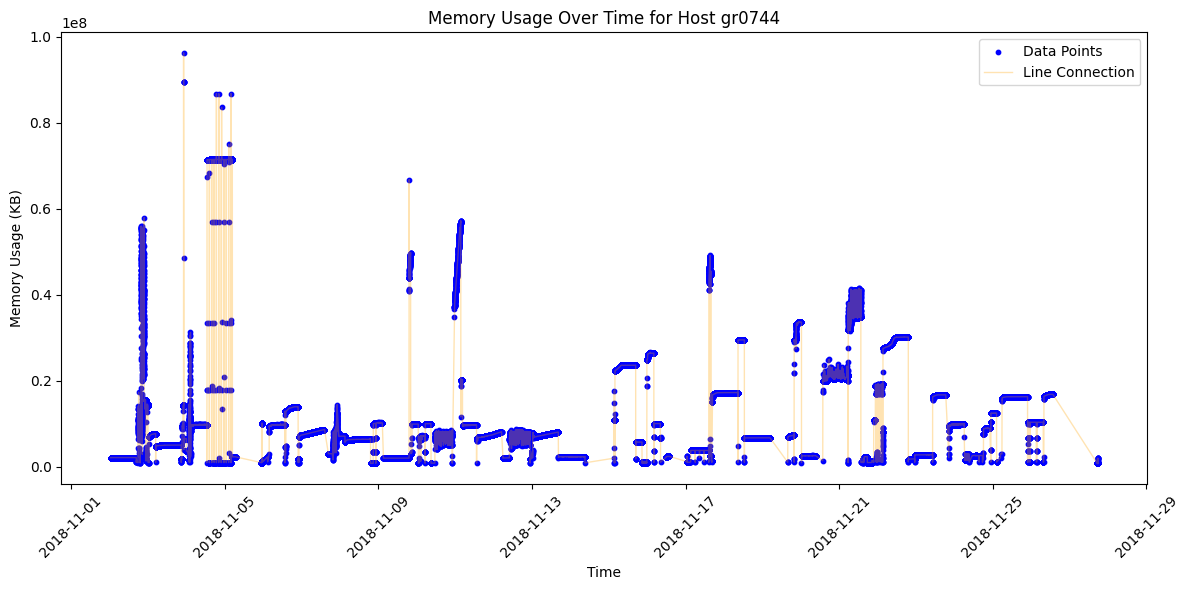

In [7]:
# Select the first host or specify a host
host_to_analyze = df_cleaned['host'].unique()[0]
df_host = df_cleaned[df_cleaned['host'] == host_to_analyze]

# Sort the data by the timestamp to ensure lines are drawn left-to-right
df_host = df_host.sort_index()

# Plot memory usage over time for the selected host
plt.figure(figsize=(12, 6))

# First, plot points only
plt.scatter(df_host.index, df_host['value'], label='Data Points', color='blue', s=10)

# Then, draw lines from left to right with transparency
plt.plot(df_host.index, df_host['value'], linestyle='-', color='orange', linewidth=1, alpha=0.3, label='Line Connection')

# Improve plot appearance
plt.title(f"Memory Usage Over Time for Host {host_to_analyze}")
plt.xlabel("Time")
plt.ylabel("Memory Usage (KB)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Save the plot as a PNG file
file_path = os.path.join(output_folder, 'memory_usage_time_host_transparent_lines.png')
plt.savefig(file_path, format='png')
plt.show()


Identify peak usage periods

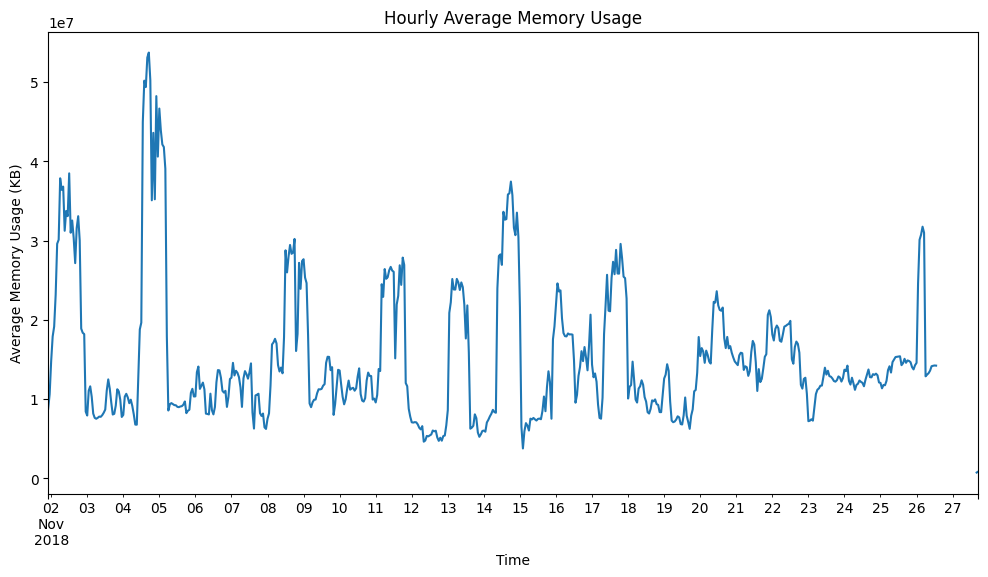

Top 5 Peak Memory Usage Periods:
timestamp
2018-11-04 17:00:00    5.371578e+07
2018-11-04 16:00:00    5.308642e+07
2018-11-04 18:00:00    5.022449e+07
2018-11-04 14:00:00    5.016775e+07
2018-11-04 15:00:00    4.936235e+07
Name: value, dtype: float64


In [8]:
# Resample to hourly intervals and calculate the mean memory usage
memory_usage_hourly = df_cleaned['value'].resample('H').mean()

# Plot the hourly average memory usage
plt.figure(figsize=(12,6))
memory_usage_hourly.plot()
plt.title("Hourly Average Memory Usage")
plt.xlabel("Time")
plt.ylabel("Average Memory Usage (KB)")
file_path = os.path.join(output_folder, 'hourly_avg_memory_usage.png')
plt.savefig(file_path, format='png')
plt.show()

# Find the top 5 peak usage periods
peak_usage = memory_usage_hourly.nlargest(5)
print("Top 5 Peak Memory Usage Periods:")
print(peak_usage)


### Correlation Analysis

**1. Correlation Between Memory Usage and Time of Day**

  Objective: Determine if memory usage varies with the time of day, which could indicate peak usage periods or patterns in job scheduling.

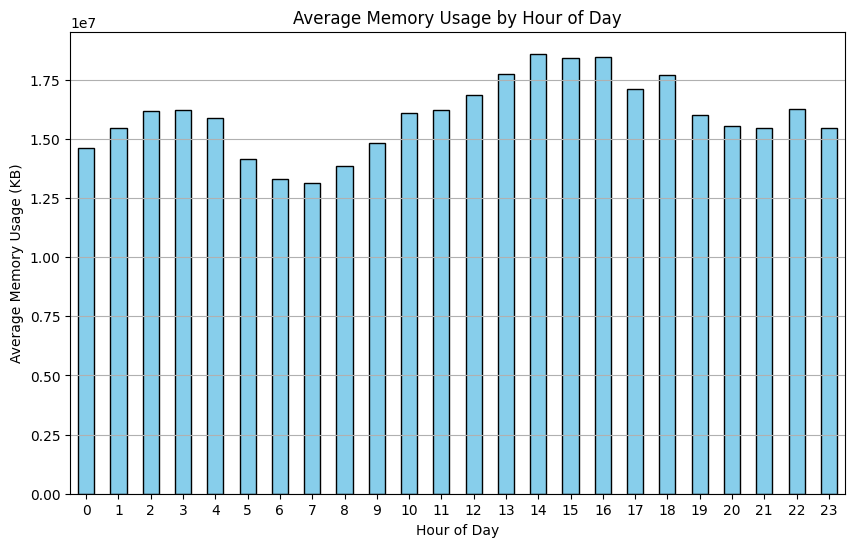

Correlation between Hour of Day and Memory Usage: 0.0312


In [9]:
# df_cleaned.set_index('timestamp', inplace=True)
# Extract hour from timestamp
df_cleaned['hour'] = df_cleaned.index.hour
# Calculate average memory usage per hour
hourly_memory_usage = df_cleaned.groupby('hour')['value'].mean()
# Plot average memory usage by hour
plt.figure(figsize=(10, 6))
hourly_memory_usage.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Memory Usage by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Memory Usage (KB)")
plt.xticks(rotation=0)
plt.grid(axis='y')
file_path = os.path.join(output_folder, 'avg_memory_usage_hour_day.png')
plt.savefig(file_path, format='png')
plt.show()


# Calculate correlation between hour and memory usage
df_cleaned.reset_index(inplace=True)  # Reset index to access 'timestamp' as a column
corr_hour_memory = df_cleaned[['hour', 'value']].corr().iloc[0,1]
print(f"Correlation between Hour of Day and Memory Usage: {corr_hour_memory:.4f}")

**Interpretation:** [EDIT]

* Positive Correlation: Memory usage increases during certain hours, indicating peak usage times.
* Negative Correlation: Memory usage decreases during certain hours.
* Correlation Coefficient: Values range from -1 to 1.
  * Closer to 1: Strong positive correlation.
  * Closer to -1: Strong negative correlation.
  * Around 0: No linear correlation.




**2. Correlation Between Memory Usage and Job IDs**

  Objective: Identify if certain jobs are associated with higher memory usage.



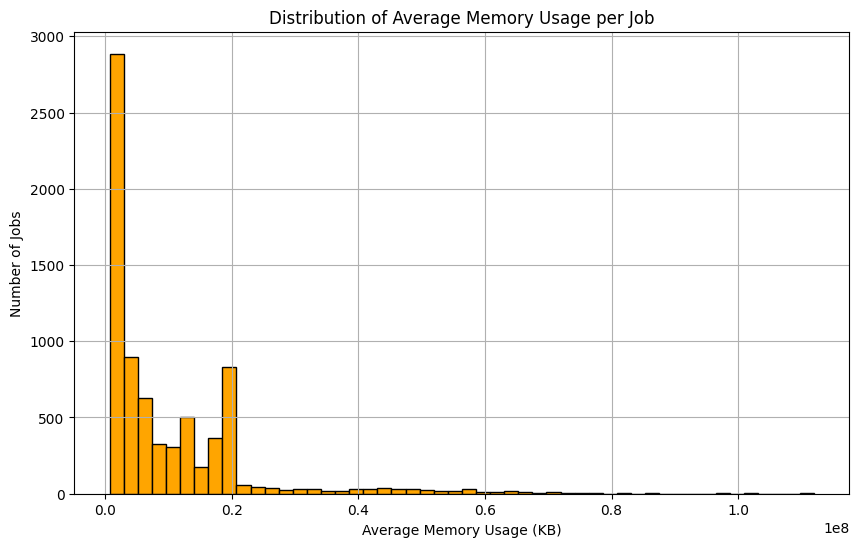

Top 10 Jobs by Average Memory Usage:
jobid
15025738    1.119872e+08
15026331    1.118155e+08
15019913    1.115384e+08
15022432    1.103657e+08
15024808    1.075079e+08
15023135    1.041621e+08
15021265    1.026373e+08
15021347    1.019865e+08
15022881    1.014751e+08
15020344    9.768831e+07
Name: value, dtype: float64


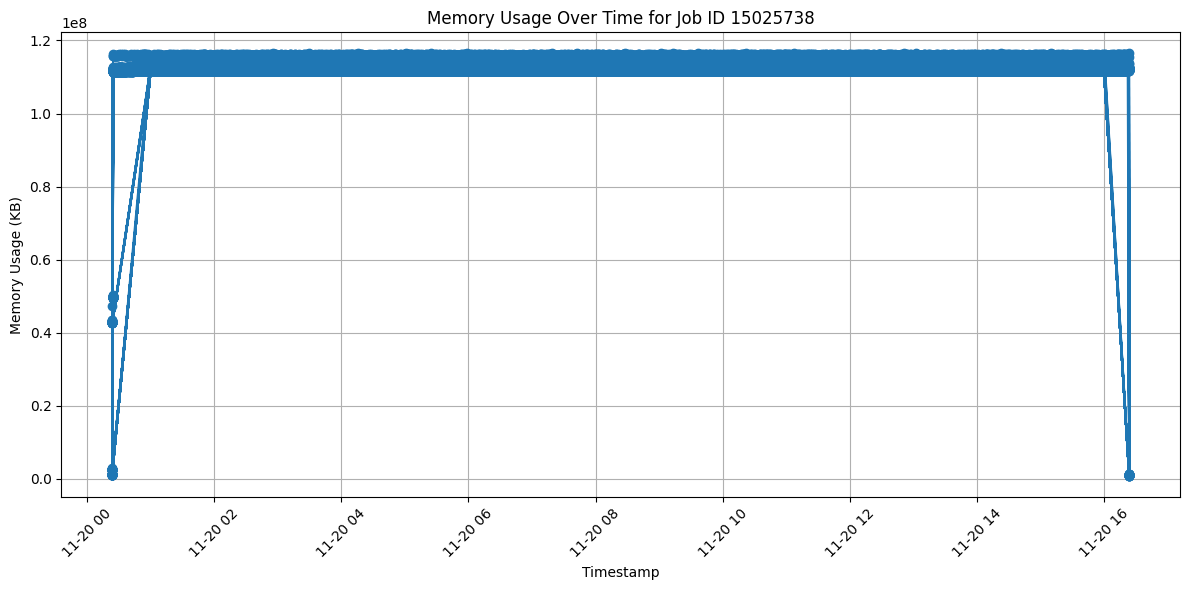

In [10]:
# Calculate average memory usage per job
job_memory_usage = df_cleaned.groupby('jobid')['value'].mean()

# Plot distribution of average memory usage per job
plt.figure(figsize=(10,6))
plt.hist(job_memory_usage, bins=50, color='orange', edgecolor='black')
plt.title("Distribution of Average Memory Usage per Job")
plt.xlabel("Average Memory Usage (KB)")
plt.ylabel("Number of Jobs")
plt.grid(True)
file_path = os.path.join(output_folder, 'dist_avg_memory_usage_per_job.png')
plt.savefig(file_path, format='png')
plt.show()

# Identify top 10 jobs with highest average memory usage
top_jobs = job_memory_usage.sort_values(ascending=False).head(10)
print("Top 10 Jobs by Average Memory Usage:")
print(top_jobs)

# Plot memory usage over time for the top job
top_job_id = top_jobs.index[0]
df_top_job = df_cleaned[df_cleaned['jobid'] == top_job_id]

plt.figure(figsize=(12,6))
plt.plot(df_top_job['timestamp'], df_top_job['value'], marker='o')
plt.title(f"Memory Usage Over Time for Job ID {top_job_id}")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (KB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
file_path = os.path.join(output_folder, 'memory_usage_time_job.png')
plt.savefig(file_path, format='png')
plt.show()


**Interpretation:** [EDIT]

Jobs with higher average memory usage might be computationally intensive or inefficient.

Understanding these jobs can help in optimizing resource allocation.

**3. Correlation Between Memory Usage and Hosts (Nodes)**

  Objective: Discover if certain hosts consistently exhibit higher memory usage.

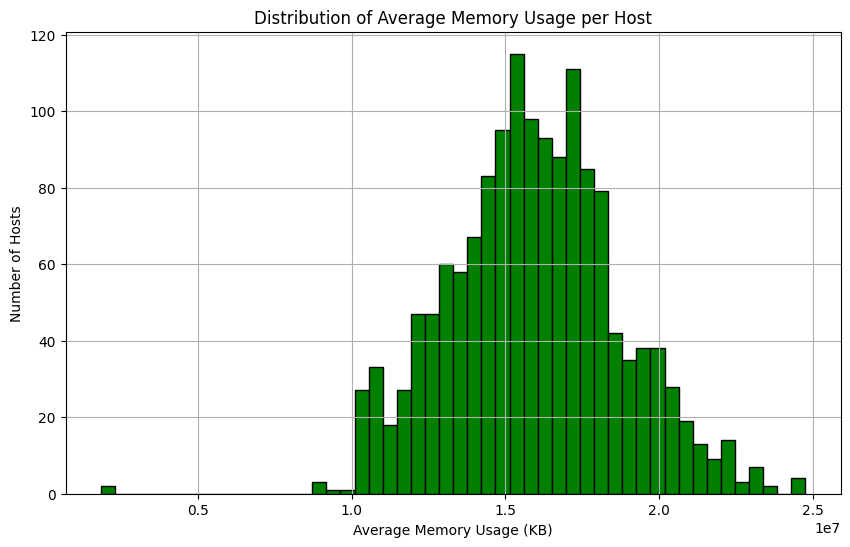

Top 10 Hosts by Average Memory Usage:
host
gr1264    2.476880e+07
gr1261    2.470163e+07
gr1263    2.450661e+07
gr1262    2.437339e+07
gr0262    2.370480e+07
gr1159    2.341580e+07
gr1259    2.329918e+07
gr1251    2.328495e+07
gr1252    2.318865e+07
gr1253    2.310740e+07
Name: value, dtype: float64


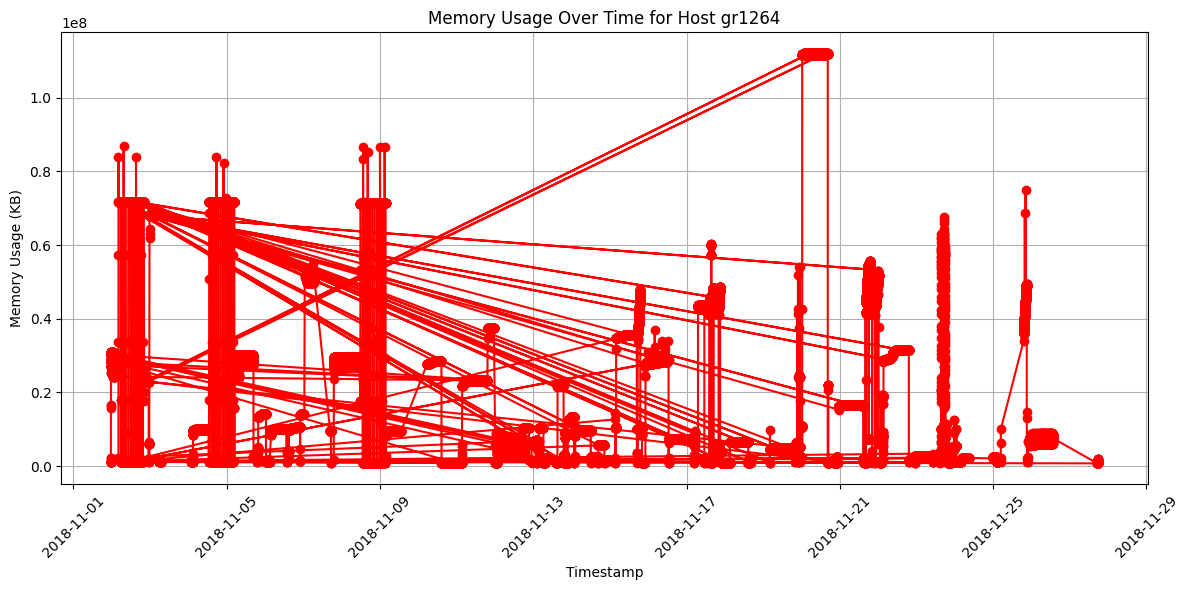

In [11]:
# Calculate average memory usage per host
host_memory_usage = df_cleaned.groupby('host')['value'].mean()

# Plot distribution of average memory usage per host
plt.figure(figsize=(10,6))
plt.hist(host_memory_usage, bins=50, color='green', edgecolor='black')
plt.title("Distribution of Average Memory Usage per Host")
plt.xlabel("Average Memory Usage (KB)")
plt.ylabel("Number of Hosts")
plt.grid(True)
file_path = os.path.join(output_folder, 'dist_avg_memory_usage_host.png')
plt.savefig(file_path, format='png')
plt.show()

# Identify top 10 hosts with highest average memory usage
top_hosts = host_memory_usage.sort_values(ascending=False).head(10)
print("Top 10 Hosts by Average Memory Usage:")
print(top_hosts)

# Plot memory usage over time for the top host
top_host = top_hosts.index[0]
df_top_host = df_cleaned[df_cleaned['host'] == top_host]

plt.figure(figsize=(12,6))
plt.plot(df_top_host['timestamp'], df_top_host['value'], marker='o', color='red')
plt.title(f"Memory Usage Over Time for Host {top_host}")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (KB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
file_path = os.path.join(output_folder, 'memory_usage_time_host.png')
plt.savefig(file_path, format='png')
plt.show()


**Interpretation:** [EDIT]

Hosts with consistently high memory usage may require maintenance or load balancing.

Insights can help in improving overall cluster performance.

**4. Correlation Between Memory Usage and Job Duration**

Objective: Assess whether longer-running jobs consume more memory.



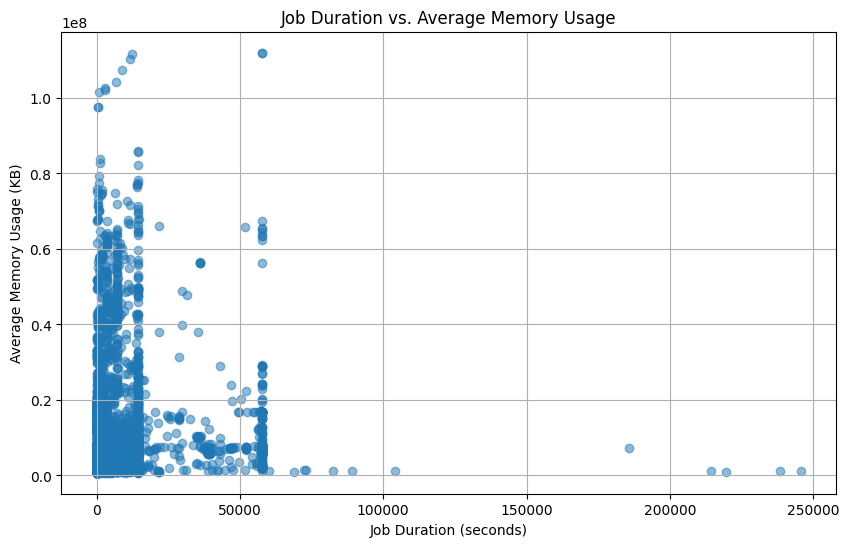

Correlation between Job Duration and Average Memory Usage: 0.0433


In [12]:
# Calculate start and end times for each job
job_times = df_cleaned.groupby('jobid')['timestamp'].agg(['min', 'max'])
job_times['duration'] = (job_times['max'] - job_times['min']).dt.total_seconds()

# Compute average memory usage per job
job_memory_usage = df_cleaned.groupby('jobid')['value'].mean()

# Merge job duration and average memory usage
job_analysis = pd.concat([job_times['duration'], job_memory_usage], axis=1).dropna()

# Plot scatter plot of job duration vs. average memory usage
plt.figure(figsize=(10,6))
plt.scatter(job_analysis['duration'], job_analysis['value'], alpha=0.5)
plt.title("Job Duration vs. Average Memory Usage")
plt.xlabel("Job Duration (seconds)")
plt.ylabel("Average Memory Usage (KB)")
plt.grid(True)
file_path = os.path.join(output_folder, 'job_duration_vs_avg_memory_usage.png')
plt.savefig(file_path, format='png')
plt.show()

# Calculate correlation between job duration and average memory usage
corr_duration_memory = job_analysis['duration'].corr(job_analysis['value'])
print(f"Correlation between Job Duration and Average Memory Usage: {corr_duration_memory:.4f}")


**Interpretation:** [EDIT]

* Positive Correlation: Longer jobs consume more memory on average.
* Negative Correlation: Longer jobs consume less memory on average.
* No Correlation: Job duration does not significantly impact memory usage.


**5. Temporal Memory Usage Patterns**

Objective: Identify patterns in memory usage over different days or weeks.

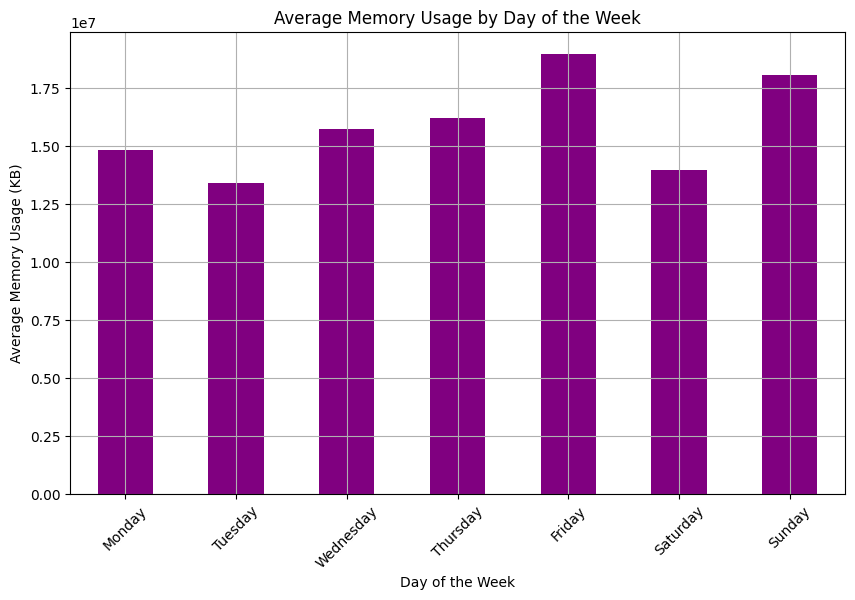

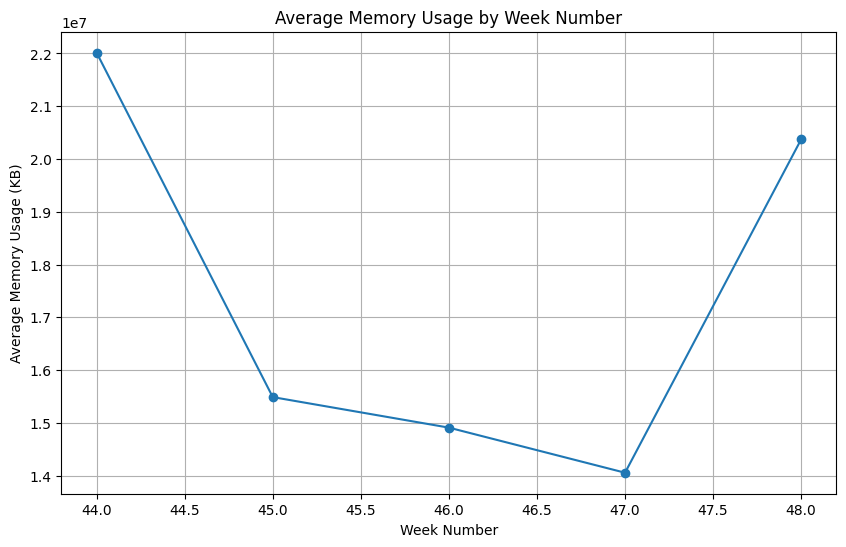

In [13]:
# Extract day of the week and week number
df_cleaned['day_of_week'] = df_cleaned['timestamp'].dt.day_name()
df_cleaned['week_number'] = df_cleaned['timestamp'].dt.isocalendar().week

# Calculate average memory usage per day of the week
daily_memory_usage = df_cleaned.groupby('day_of_week')['value'].mean()

# Reorder days for plotting
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_memory_usage = daily_memory_usage.reindex(days_order)

# Plot average memory usage by day of the week
plt.figure(figsize=(10,6))
daily_memory_usage.plot(kind='bar', color='purple')
plt.title("Average Memory Usage by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Memory Usage (KB)")
plt.xticks(rotation=45)
plt.grid(True)
file_path = os.path.join(output_folder, 'avg_memory_usage_per_day.png')
plt.savefig(file_path, format='png')
plt.show()

# Analyze memory usage over weeks
weekly_memory_usage = df_cleaned.groupby('week_number')['value'].mean()

# Plot average memory usage by week
plt.figure(figsize=(10,6))
weekly_memory_usage.plot(marker='o')
plt.title("Average Memory Usage by Week Number")
plt.xlabel("Week Number")
plt.ylabel("Average Memory Usage (KB)")
plt.grid(True)
file_path = os.path.join(output_folder, 'avg_memory_usage_week_num.png')
plt.savefig(file_path, format='png')
plt.show()


**Interpretation:** [EDIT]

* Daily Patterns: Higher memory usage on certain days may indicate batch processing or scheduled jobs.
* Weekly Trends: Variations between weeks can reveal periods of high activity.


#### **Summary of Findings** [EDIT]
By analyzing the available data, we can uncover meaningful relationships:

* Time of Day: Memory usage may peak during certain hours, indicating busy periods.
* Job IDs: Specific jobs consume more memory, which could be targets for optimization.
* Hosts: Certain nodes may be under higher load, suggesting the need for resource balancing.
* Job Duration: The relationship between how long jobs run and their memory usage can inform scheduling decisions.
* Temporal Patterns: Daily and weekly trends help in planning maintenance and managing workloads.

## **Data Visualization**

**1. Line Charts: Visualize Trends in Resource Usage Over Time**

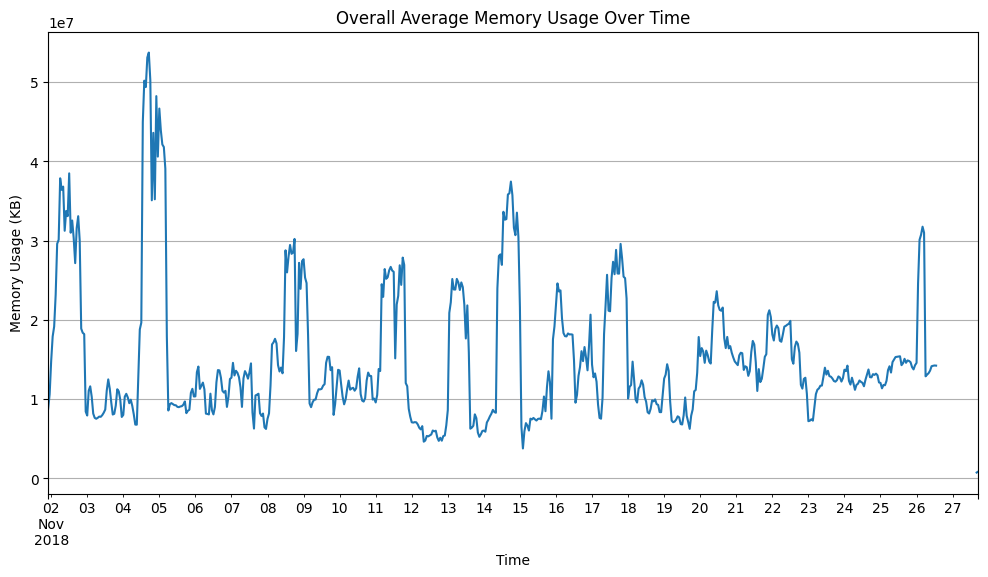

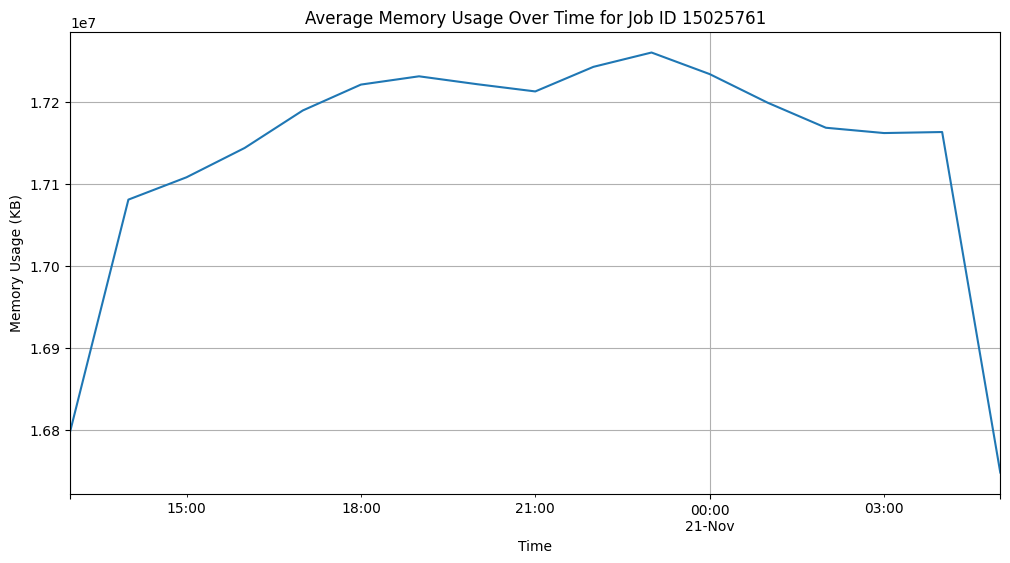

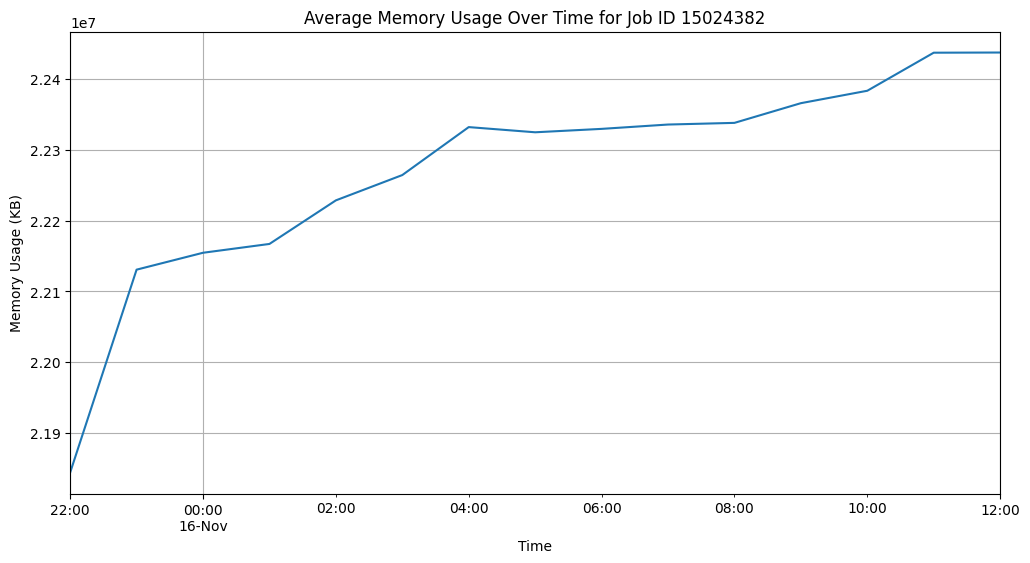

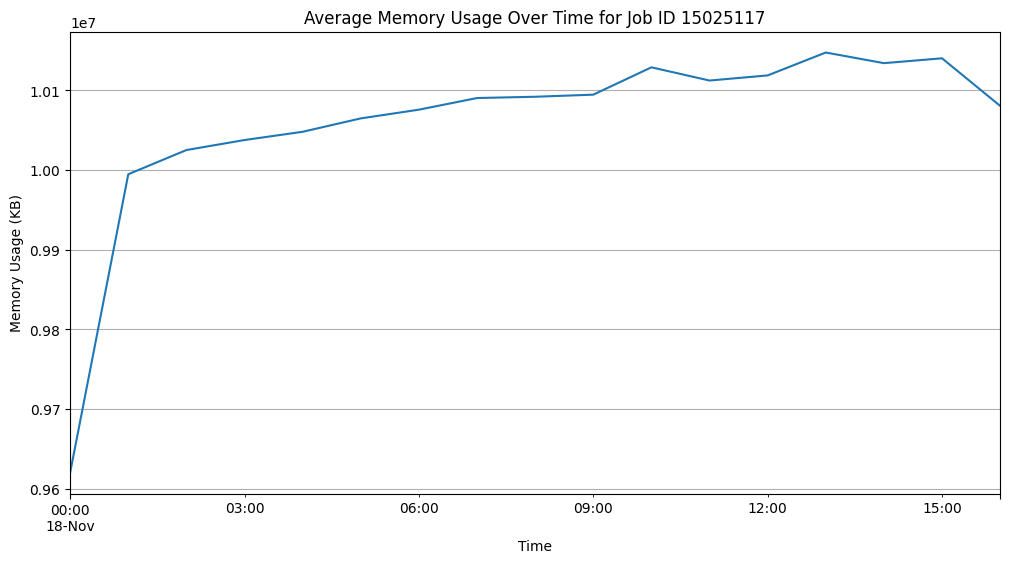

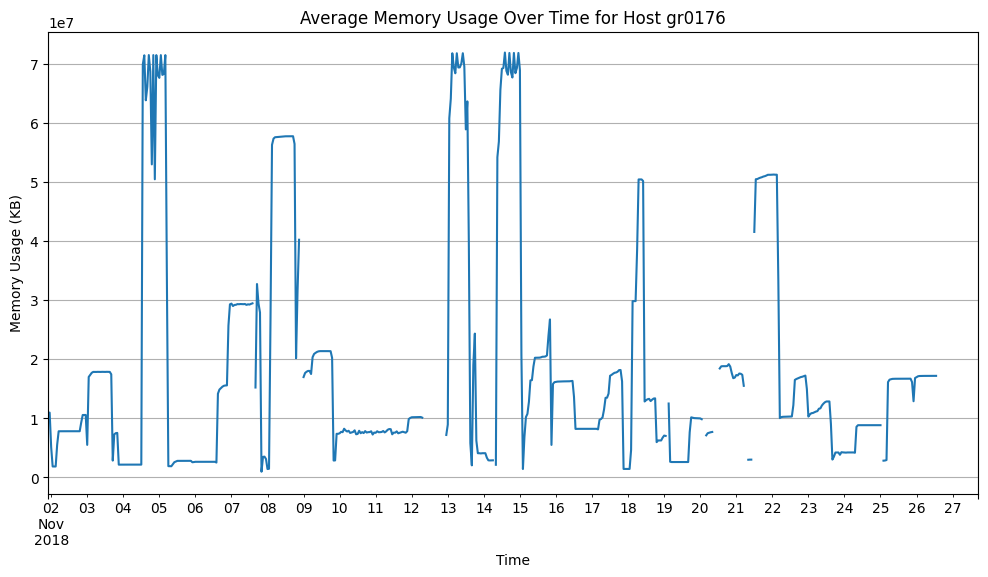

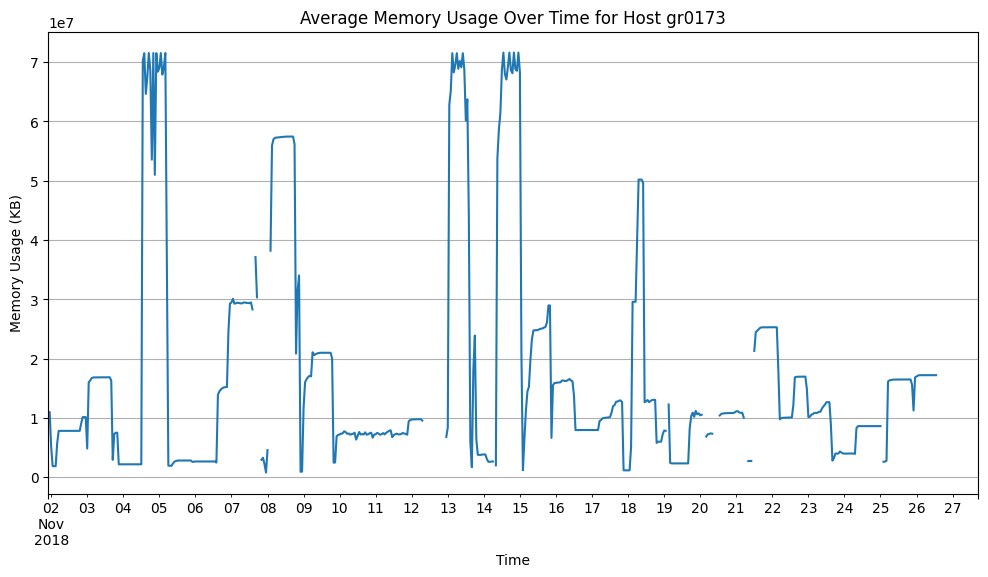

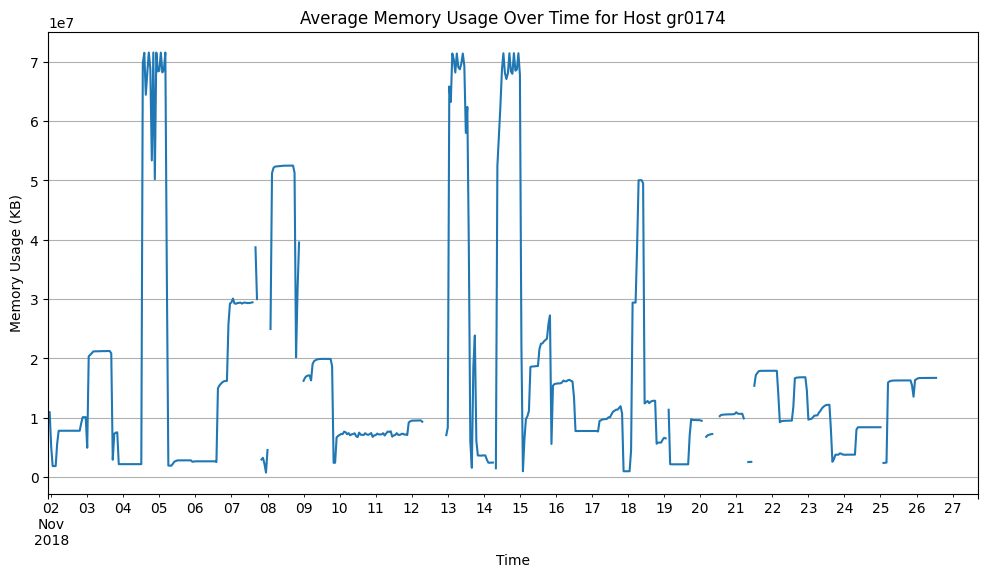

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure timestamp is datetime and set as index
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])
df_cleaned.set_index('timestamp', inplace=True)

# Overall Memory Usage Over Time
plt.figure(figsize=(12,6))
df_cleaned['value'].resample('H').mean().plot()
plt.title("Overall Average Memory Usage Over Time")
plt.xlabel("Time")
plt.ylabel("Memory Usage (KB)")
plt.grid(True)
file_path = os.path.join(output_folder, 'overall_avg_memory_usage_time.png')
plt.savefig(file_path, format='png')
plt.show()

# Memory Usage Over Time for Top 3 Jobs
top_jobs = df_cleaned['jobid'].value_counts().head(3).index
for job in top_jobs:
    df_job = df_cleaned[df_cleaned['jobid'] == job]
    plt.figure(figsize=(12,6))
    df_job['value'].resample('H').mean().plot()
    plt.title(f"Average Memory Usage Over Time for Job ID {job}")
    plt.xlabel("Time")
    plt.ylabel("Memory Usage (KB)")
    plt.grid(True)
    file_path = os.path.join(output_folder, 'avg_memory_usage_time_jobid{job}.png')
    plt.savefig(file_path, format='png')
    plt.show()

# Memory Usage Over Time for Top 3 Hosts
top_hosts = df_cleaned['host'].value_counts().head(3).index
for host in top_hosts:
    df_host = df_cleaned[df_cleaned['host'] == host]
    plt.figure(figsize=(12,6))
    df_host['value'].resample('H').mean().plot()
    plt.title(f"Average Memory Usage Over Time for Host {host}")
    plt.xlabel("Time")
    plt.ylabel("Memory Usage (KB)")
    plt.grid(True)
    file_path = os.path.join(output_folder, 'avg_memory_usage_time{host}.png')
    plt.savefig(file_path, format='png')
    plt.show()


**2. Heatmaps: Show Resource Usage Across Different Nodes and Times**

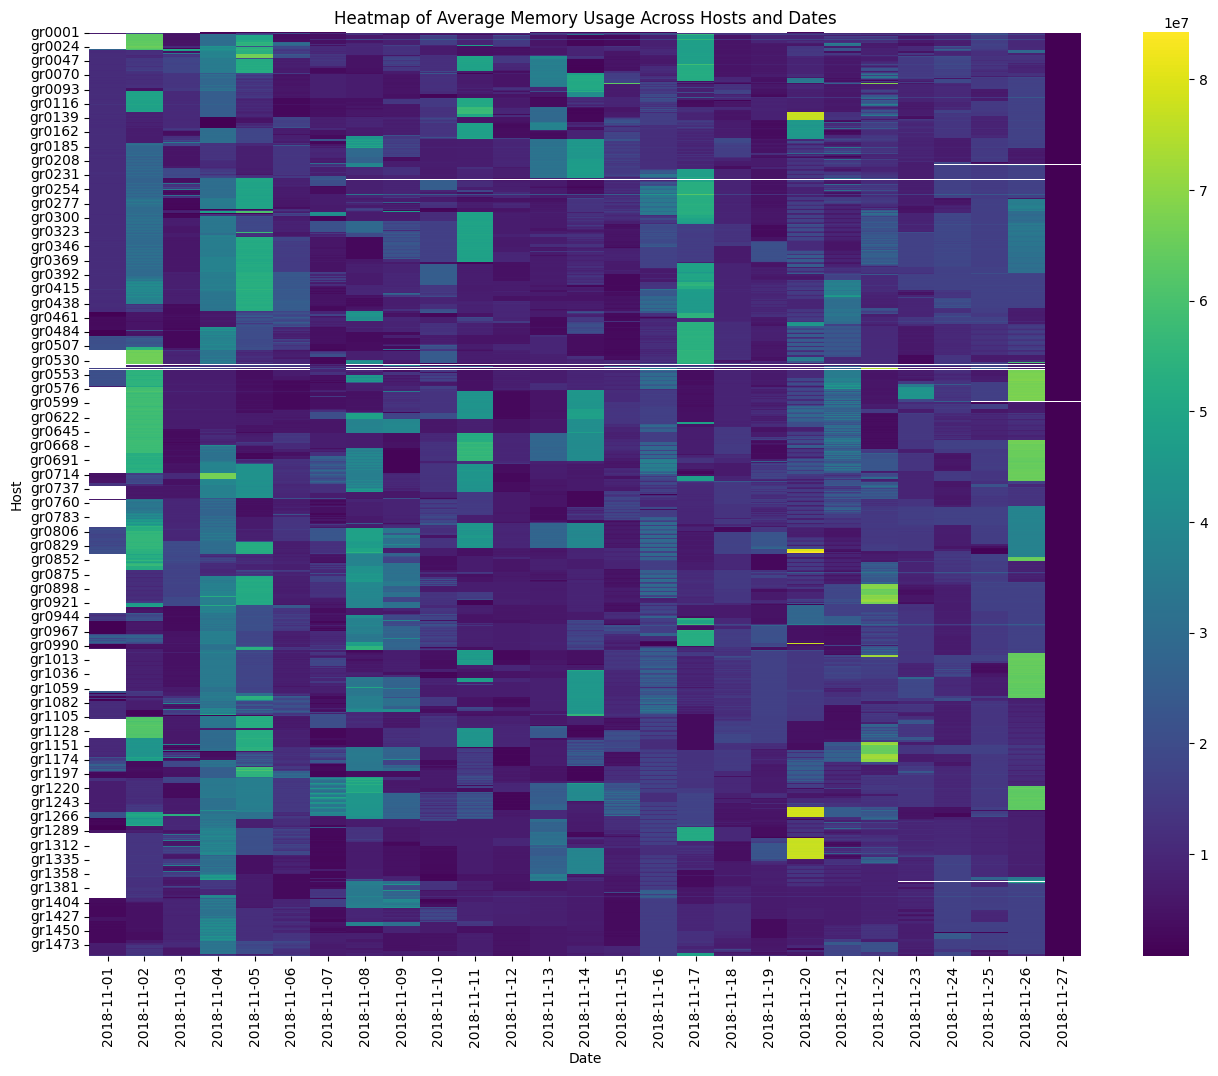

In [15]:
import seaborn as sns
import numpy as np

# Create a pivot table for hosts and time
# We'll resample data to a daily frequency for better visualization
df_daily = df_cleaned.reset_index()
df_daily['date'] = df_daily['timestamp'].dt.date

pivot_table = df_daily.pivot_table(values='value', index='host', columns='date', aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(16,12))
sns.heatmap(pivot_table, cmap='viridis')
plt.title("Heatmap of Average Memory Usage Across Hosts and Dates")
plt.xlabel("Date")
plt.ylabel("Host")
file_path = os.path.join(output_folder, 'heatmap_avg_memory_usage_hosts_dates.png')
plt.savefig(file_path, format='png')
plt.show()


**3. Interactive Dashboards: Use Plotly for Dynamic Visualizations**

In [16]:
import plotly.express as px

# Interactive Line Chart of Overall Memory Usage
df_hourly = df_cleaned['value'].resample('H').mean().reset_index()

# Create the plot
fig = px.line(df_hourly, x='timestamp', y='value', title='Interactive Memory Usage Over Time')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(xaxis_title='Time', yaxis_title='Memory Usage (KB)')

# Save the plot as HTML
fig.write_html("overall_memory_usage.html")

# Interactive Line Chart for Top Job
top_job = df_cleaned['jobid'].value_counts().idxmax()
df_top_job = df_cleaned[df_cleaned['jobid'] == top_job]['value'].resample('H').mean().reset_index()

# Create the plot
fig = px.line(df_top_job, x='timestamp', y='value', title=f'Interactive Memory Usage Over Time for Job ID {top_job}')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(xaxis_title='Time', yaxis_title='Memory Usage (KB)')
fig.show()

# Save the plot as HTML
fig.write_html(f"full_dataset_analysis_plots/memory_usage_top_job_{top_job}.html")

print("Plots saved as HTML files.")



Plots saved as HTML files.


**4. Anomaly Detection Visuals: Highlight Outliers or Unusual Patterns**

### *Isolation forest*

### **Summary** [EDIT]

* Line Charts: Visualizing trends in memory usage over time, both overall and for specific jobs and hosts.
* Heatmaps: Showing resource usage across different nodes (hosts) and dates.
* Interactive Dashboards: Using Plotly to create interactive line charts, and an example of a Dash app for more advanced interaction.
* Anomaly Detection Visuals: Highlighting outliers in memory usage using the Isolation Forest algorithm and plotting anomalies over time.

## **Advanced Analytics**

### 1. Anomaly Detection

**Objective**: Detect anomalies in memory usage data using machine learning algorithms like Isolation Forest and DBSCAN.

* Isolation Forest
  
    Approach:

    * Use the Isolation Forest algorithm to detect anomalies in the memory usage data.
    * The model will consider points that are significantly different from the rest as anomalies.


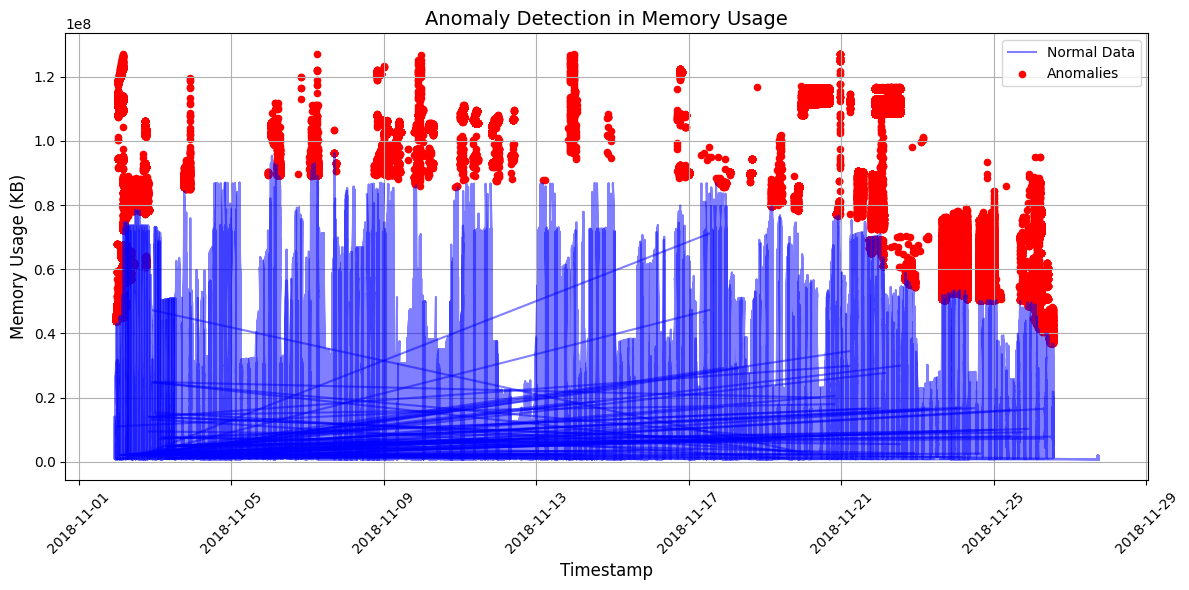

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure Matplotlib to handle large datasets
rcParams['agg.path.chunksize'] = 10000

# Prepare data for anomaly detection
df_anomaly = df_cleaned.copy()
df_anomaly.reset_index(inplace=True)

# Convert timestamp to numerical format for Isolation Forest
df_anomaly['timestamp_numeric'] = df_anomaly['timestamp'].astype('int64') // 10**9  # Convert to seconds

# Feature set for Isolation Forest
X = df_anomaly[['timestamp_numeric', 'value']]

# Fit Isolation Forest
contamination_rate = 0.01  # Proportion of anomalies expected in the data
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
df_anomaly['anomaly_score'] = iso_forest.fit_predict(X)

# Separate anomalies and normal data
anomalies = df_anomaly[df_anomaly['anomaly_score'] == -1]
normal_data = df_anomaly[df_anomaly['anomaly_score'] == 1]

# Downsample data for faster plotting (optional for large datasets)
n = 100  # Take every nth row for normal data
normal_data_downsampled = normal_data.iloc[::n]

# Plot anomalies and normal data
plt.figure(figsize=(12, 6))
plt.plot(
    normal_data_downsampled['timestamp'],
    normal_data_downsampled['value'],
    label='Normal Data',
    color='blue',
    alpha=0.5  # Add transparency for overlapping points
)
plt.scatter(
    anomalies['timestamp'],
    anomalies['value'],
    color='red',
    label='Anomalies',
    s=20  # Set size of anomaly points
)

# Add labels, title, and legend
plt.title("Anomaly Detection in Memory Usage", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Memory Usage (KB)", fontsize=12)
plt.legend()
plt.grid(True)  # Add gridlines for better readability
plt.xticks(rotation=45, fontsize=10)
file_path = os.path.join(output_folder, 'anomaly_detection_memory_usage.png')
plt.savefig(file_path, format='png')
plt.tight_layout()

# Save the plot as an image file (optional)

# Show the plot
plt.show()


*Explanation:*

* Isolation Forest isolates anomalies instead of profiling normal data.
* The contamination parameter (0.01) indicates that we expect about 1% of the data to be anomalies.
* We converted timestamps to numeric values since the model cannot process datetime objects.

* DBSCAN

  Approach:

  * Use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) for anomaly detection.
  * DBSCAN clusters data points that are closely packed and labels points in low-density regions as outliers.

DBSCAN code is present in a different file.

*Explanation:*

* DBSCAN groups together points that are closely packed.
* Points that lie alone in low-density regions are considered anomalies (noise).
* Parameters eps and min_samples can be adjusted based on data characteristics.


### 2. Clustering

**Objective**: Group jobs with similar resource usage patterns using K-Means or Hierarchical Clustering.

* K-Means Clustering

  Approach:

  * Aggregate memory usage data per job to create features.
  * Use K-Means clustering to group jobs based on these features.

c:\Users\kruth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\kruth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\kruth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\kruth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

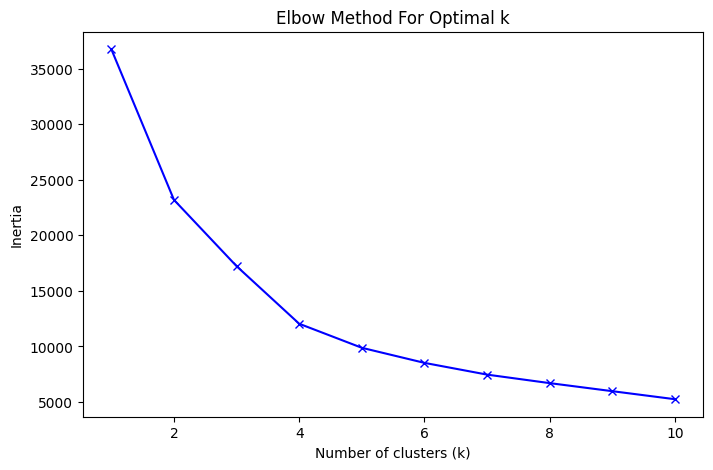

c:\Users\kruth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



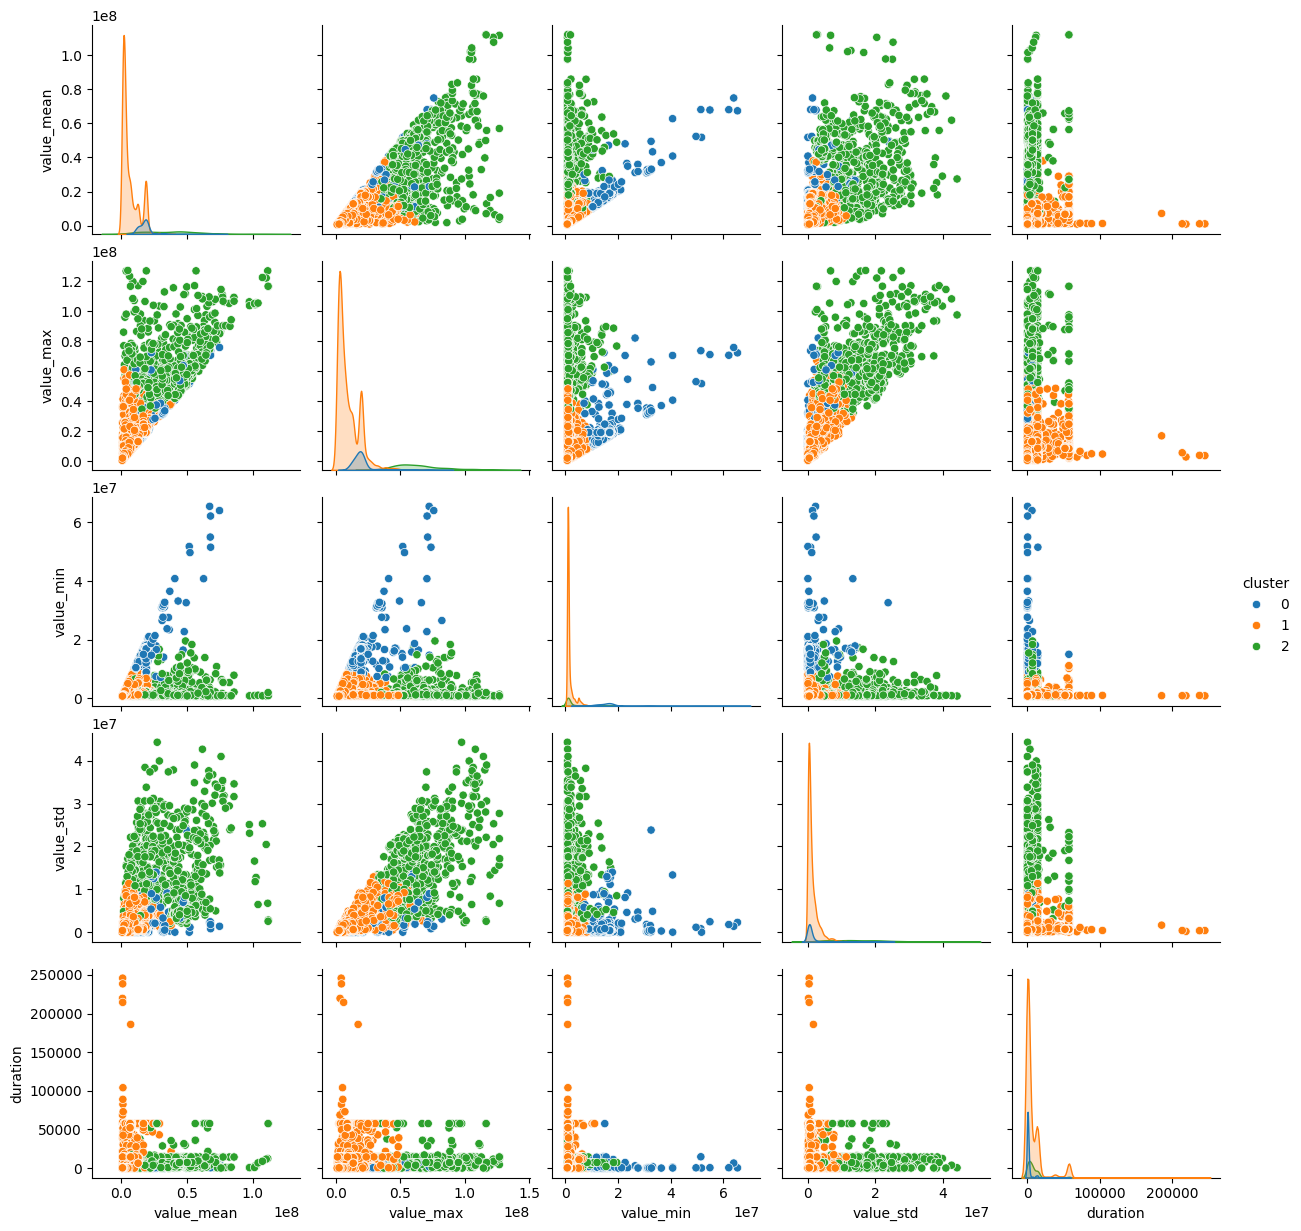

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
df_cleaned = df_cleaned.reset_index()
# Aggregate features per job
job_features = df_cleaned.groupby('jobid').agg({
    'value': ['mean', 'max', 'min', 'std'],
    'timestamp': ['min', 'max']
})

# Flatten column names
job_features.columns = ['_'.join(col).strip() for col in job_features.columns.values]

# Calculate job duration in seconds
job_features['duration'] = (job_features['timestamp_max'] - job_features['timestamp_min']).dt.total_seconds()

# Replace NaN and infinite values
job_features.replace([np.inf, -np.inf], np.nan, inplace=True)
job_features.dropna(inplace=True)

# Select features for clustering
features = ['value_mean', 'value_max', 'value_min', 'value_std', 'duration']
X = job_features[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
file_path = os.path.join(output_folder, 'elbow_method_optimal_k.png')
plt.savefig(file_path, format='png')
plt.show()

# Choose k where the inertia starts to level off (elbow point), e.g., k=3
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
job_features['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
sns.pairplot(job_features, vars=features, hue='cluster', palette='tab10')
file_path = os.path.join(output_folder, 'job_features_clusters.png')
plt.savefig(file_path, format='png')
plt.show()


*Explanation:*

* Elbow Method helps determine the optimal number of clusters by looking for a "knee" in the inertia plot.
* Pairplot allows us to visualize the clusters across different feature combinations.

* Hierarchical Clustering
  
  Approach:

  * Use hierarchical clustering to create a dendrogram and determine clusters.

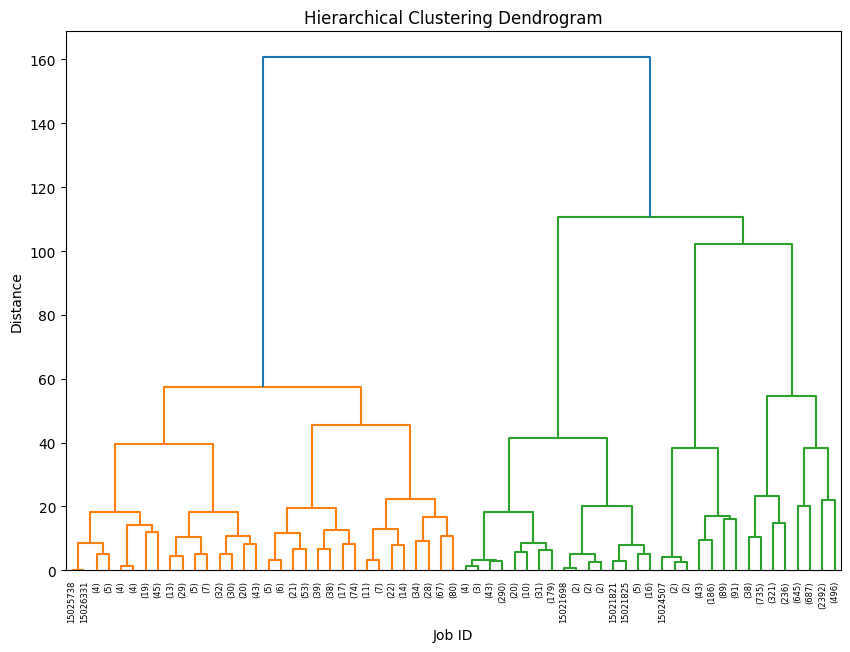

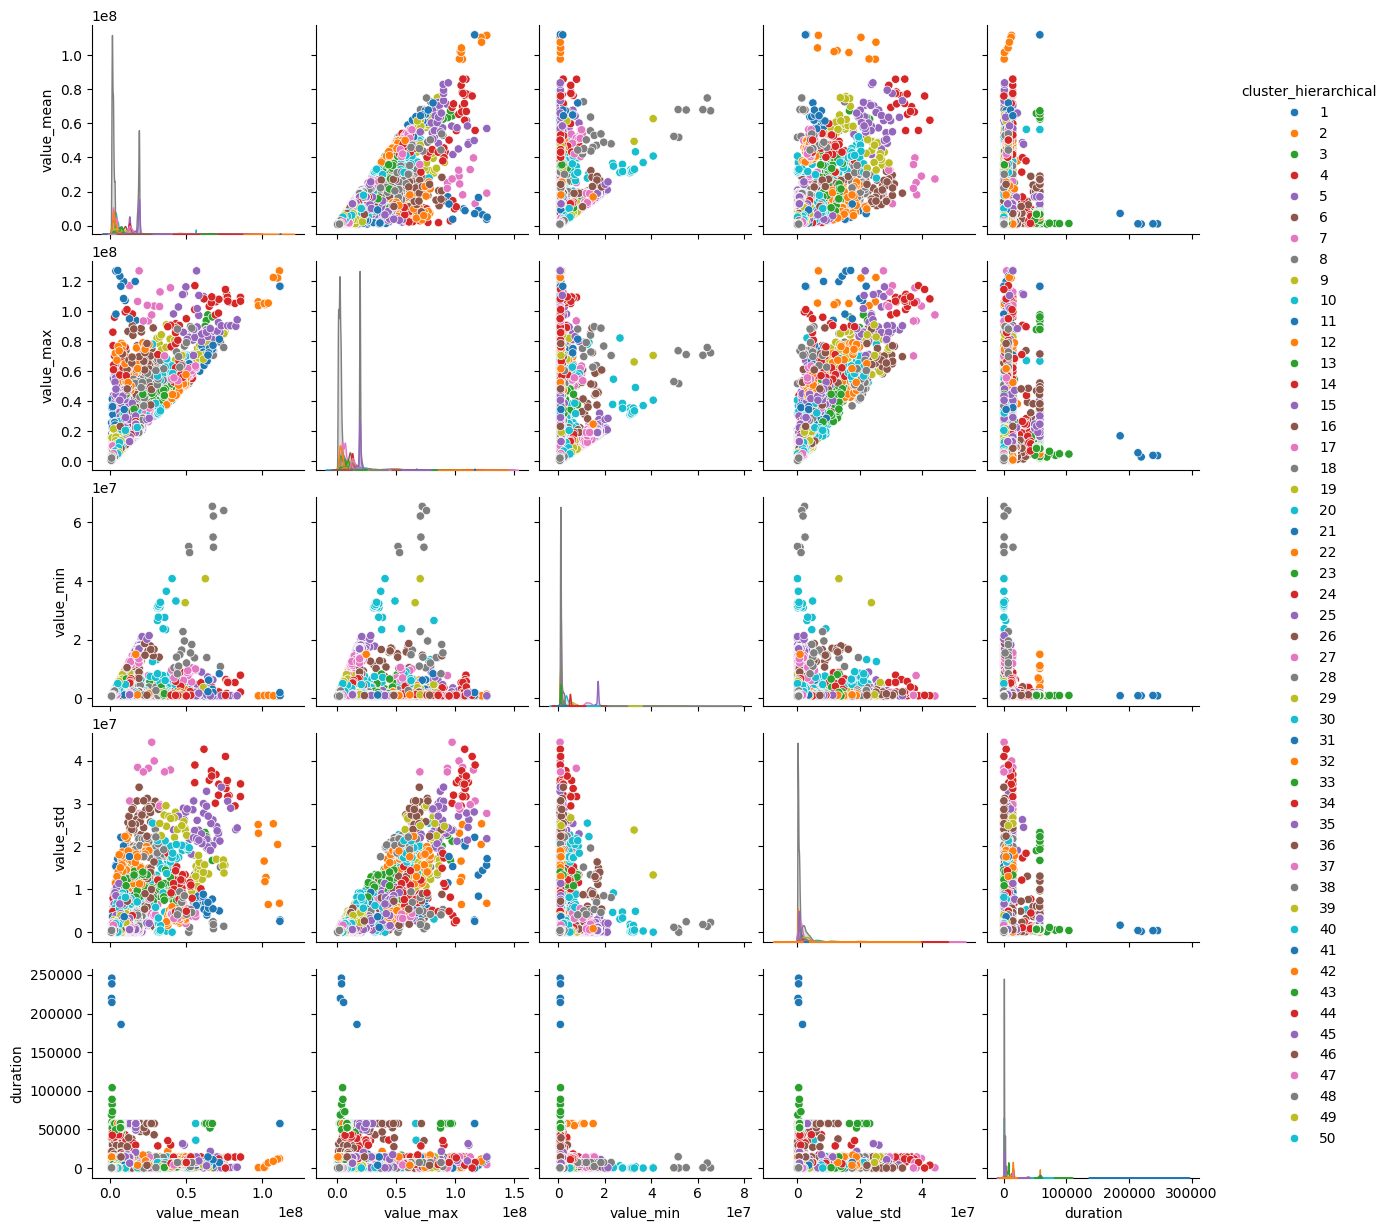

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical/agglomerative clustering
linked = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           labels=job_features.index.astype(str),
           truncate_mode='level',  # show only the last p merged clusters
           p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Job ID')
plt.ylabel('Distance')
file_path = os.path.join(output_folder, 'hierarchial_clustering_dendogram.png')
plt.savefig(file_path, format='png')
plt.show()

# Cut the dendrogram at a certain distance to get cluster labels
max_d = 7  # Adjust based on dendrogram
job_features['cluster_hierarchical'] = fcluster(linked, max_d, criterion='distance')

# Visualize clusters
sns.pairplot(job_features, vars=features, hue='cluster_hierarchical', palette='tab10')
file_path = os.path.join(output_folder, 'cluster_hierarchial.png')
plt.savefig(file_path, format='png')
plt.show()


*Explanation:*

* Dendrogram provides a visual representation of the hierarchical clustering process.
* By setting a threshold distance (max_d), we can decide on the number of clusters.


### 3. Predictive Modeling

**Objective**: Build models to predict future resource usage based on historical data.

* Time Series Forecasting with Prophet

  Approach:

  * Use the Prophet library for time series forecasting.
  * Prophet is robust to missing data and shifts in the trend.


c:\Users\kruth\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

23:00:07 - cmdstanpy - INFO - Chain [1] start processing
23:00:07 - cmdstanpy - INFO - Chain [1] done processing


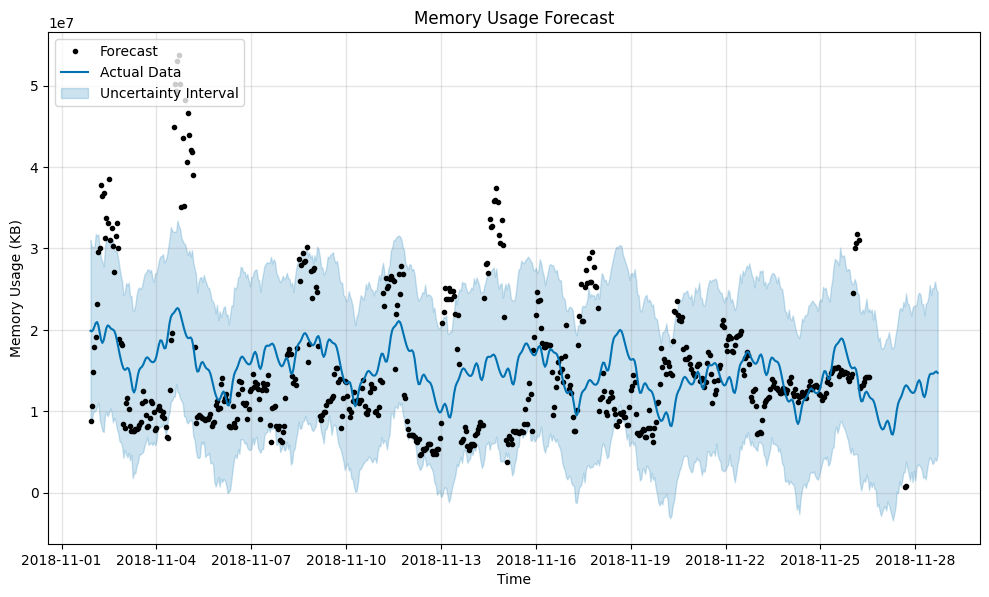

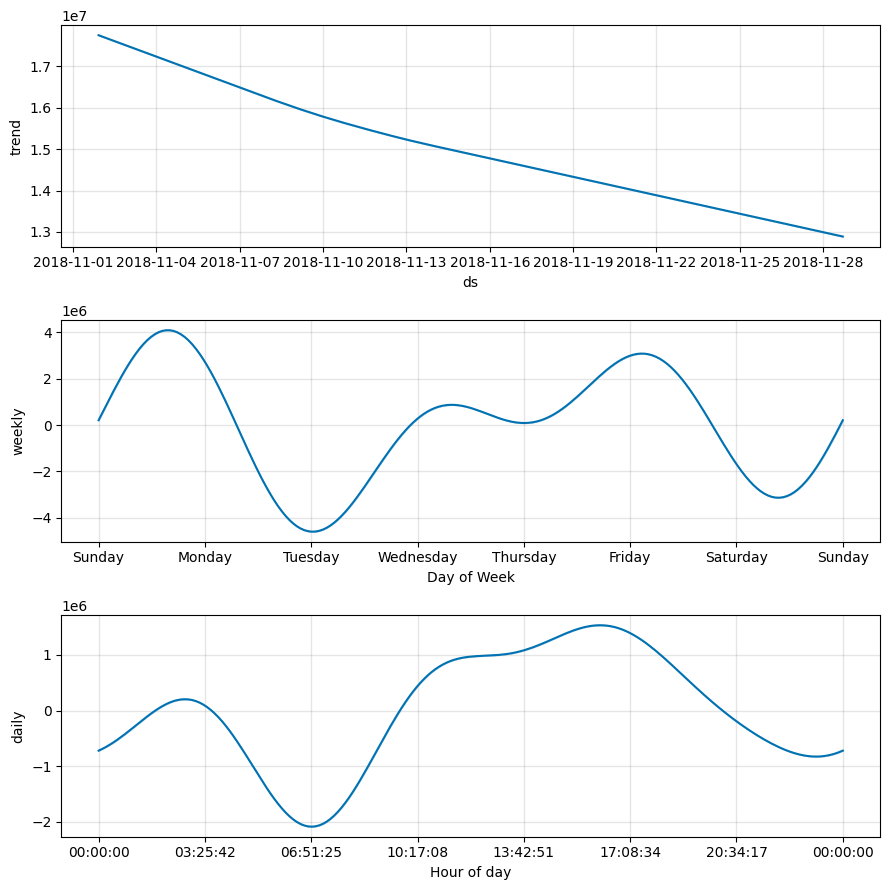

In [20]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import os

# Ensure `df_cleaned` is available and has the necessary columns
df_cleaned.reset_index(inplace=True)

# Convert the timestamp column to datetime and set it as the index
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])
df_cleaned.set_index('timestamp', inplace=True)

# Resample data to hourly frequency and prepare it for Prophet
df_prophet = df_cleaned['value'].resample('h').mean().reset_index()
df_prophet.columns = ['ds', 'y']

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Create future dataframe for prediction (24 hours into the future)
future = model.make_future_dataframe(periods=24, freq='h')
forecast = model.predict(future)

# Plot the forecast
fig_forecast = model.plot(forecast)
ax = fig_forecast.gca()  # Get the current axis of the forecast plot
ax.set_title('Memory Usage Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Memory Usage (KB)')

# Add a legend
ax.legend(['Forecast', 'Actual Data', 'Uncertainty Interval'], loc='upper left')

# Save the forecast plot
output_folder = 'output'  # Specify your output folder
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist
file_path_forecast = os.path.join(output_folder, 'memory_usage_forecast.png')
plt.savefig(file_path_forecast, format='png')
plt.show()

# Plot the forecast components
fig_components = model.plot_components(forecast)

# Save the components plot
file_path_components = os.path.join(output_folder, 'forest_components_model.png')
plt.savefig(file_path_components, format='png')
plt.show()



23:56:12 - cmdstanpy - INFO - Chain [1] start processing
23:56:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 13319187.61
Root Mean Squared Error (RMSE): 13319214.75
Mean Absolute Percentage Error (MAPE): 1700.73%


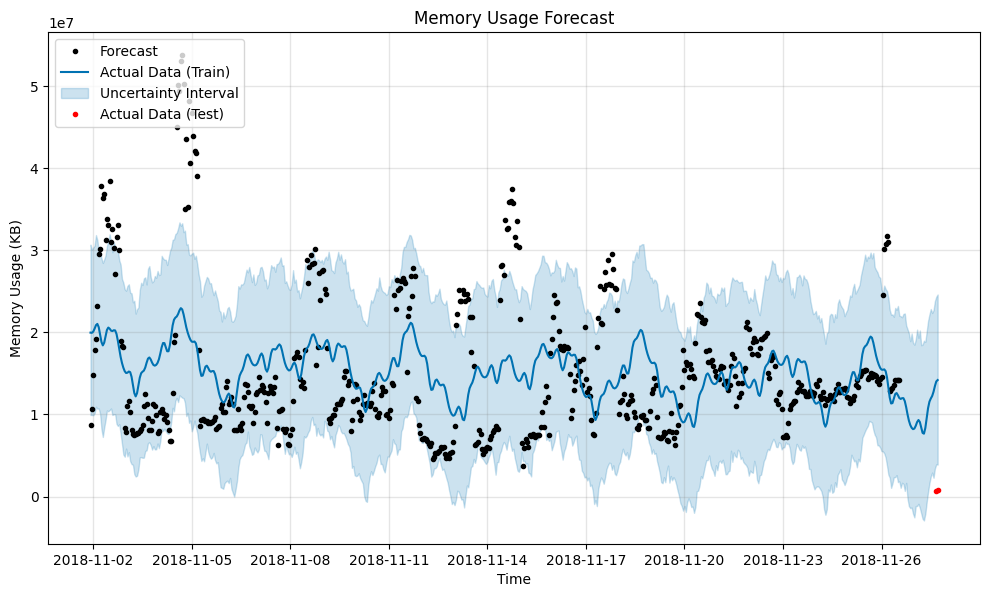

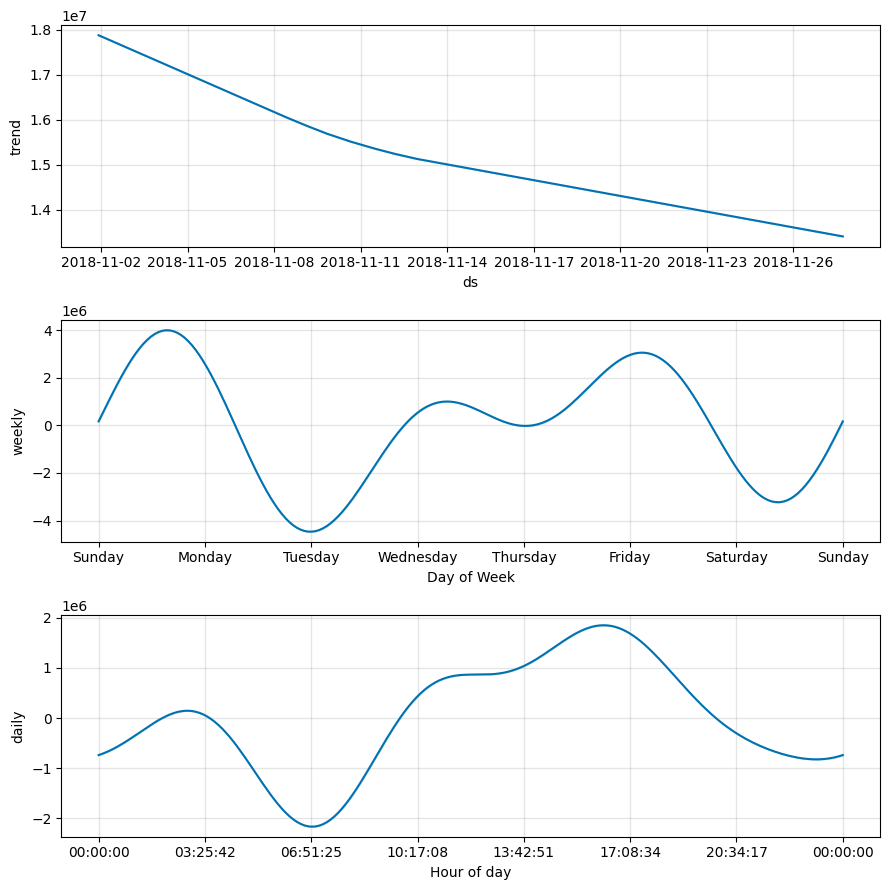

In [28]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure `df_cleaned` is available and has the necessary columns
df_cleaned.reset_index(inplace=True)

# Convert the timestamp column to datetime and set it as the index
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])
df_cleaned.set_index('timestamp', inplace=True)

# Resample data to hourly frequency and prepare it for Prophet
df_prophet = df_cleaned['value'].resample('h').mean().reset_index()
df_prophet.columns = ['ds', 'y']

# Split the data: last 24 hours for testing
train_data = df_prophet.iloc[:-24]
test_data = df_prophet.iloc[-24:]

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Create future dataframe for prediction (matching test set)
future = model.make_future_dataframe(periods=24, freq='h')
forecast = model.predict(future)

# Merge actual test data with predictions
forecast_test = forecast[['ds', 'yhat']].iloc[-24:]  # Predictions for test period
comparison = test_data.merge(forecast_test, on='ds', how='inner')

# Drop rows with NaN values
comparison = comparison.dropna()

# Check if comparison has any rows left after dropping NaN
if comparison.empty:
    print("Error: No overlapping data between test set and predictions. Check your dataset.")
else:
    # Calculate evaluation metrics
    mae = mean_absolute_error(comparison['y'], comparison['yhat'])
    rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
    mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # Plot the forecast with actual values for the test period
    fig_forecast = model.plot(forecast)
    ax = fig_forecast.gca()  # Get the current axis of the forecast plot
    ax.set_title('Memory Usage Forecast')
    ax.set_xlabel('Time')
    ax.set_ylabel('Memory Usage (KB)')

    # Overlay actual test data
    ax.plot(test_data['ds'], test_data['y'], 'r.', label='Actual Data (Test)')
    ax.legend(['Forecast', 'Actual Data (Train)', 'Uncertainty Interval', 'Actual Data (Test)'], loc='upper left')

    # Save the forecast plot
    output_folder = 'output'  # Specify your output folder
    os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist
    file_path_forecast = os.path.join(output_folder, 'memory_usage_forecast_with_actuals.png')
    plt.savefig(file_path_forecast, format='png')
    plt.show()

    # Plot the forecast components
    fig_components = model.plot_components(forecast)

    # Save the components plot
    file_path_components = os.path.join(output_folder, 'forecast_components_model.png')
    plt.savefig(file_path_components, format='png')
    plt.show()


*Explanation:*

* We resample the data to hourly averages to make the time series manageable.
* The forecast includes trend and seasonality components.

**Alternative: Using ARIMA Model**

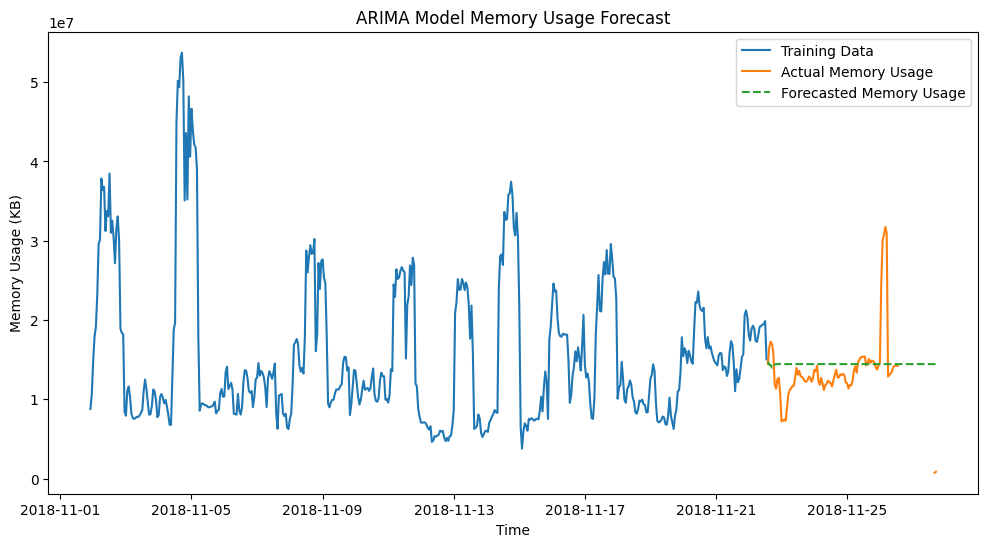

In [21]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Reset the index to make 'timestamp' a column
df_cleaned.reset_index(inplace=True)

# Ensure 'timestamp' is in datetime format
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Set 'timestamp' as the index for resampling
df_cleaned.set_index('timestamp', inplace=True)

# Resample the data to hourly averages
df_arima = df_cleaned['value'].resample('h').mean()

# Split into training and testing sets
train_size = int(len(df_arima) * 0.8)
train, test = df_arima[:train_size], df_arima[train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # Adjust order if needed
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Memory Usage')
plt.plot(test.index, forecast, label='Forecasted Memory Usage', linestyle='--')
plt.title('ARIMA Model Memory Usage Forecast')
plt.xlabel('Time')
plt.ylabel('Memory Usage (KB)')
plt.legend()
file_path = os.path.join(output_folder, 'arima_memory_usage_forecast.png')
plt.savefig(file_path, format='png')
plt.show()


*Explanation:*

* ARIMA is a classic time series forecasting model.
* The (5,1,0) order can be adjusted based on the data's autocorrelation and partial autocorrelation plots.

# **LSTM**

### 4. Job Efficiency Analysis

**Objective**: Assess how efficiently resources are utilized by different jobs.

Approach:

* Define an efficiency metric, such as average memory usage per unit of time or per unit of output if available.
* Compare jobs based on this metric to identify those that use resources efficiently.


Most Efficient Jobs:
          memory_per_second  duration
jobid                                
15020060        2743.643098     594.0
15020001        3907.173364     871.0
15021823        7912.069738    1606.0
15022615       19582.738719    3590.0
15023162       19824.983844    3590.0
15022685       20093.429508     610.0
15022722       22906.160976    1640.0
15022621       23099.230595    3530.0
15023686       23439.751471    2720.0
15022705       23693.389222    1670.0

Least Efficient Jobs:
          memory_per_second  duration
jobid                                
15008500       1.527033e+09   57620.0
15011957       1.501537e+09   57640.0
15011958       1.486040e+09   57630.0
15020422       1.477415e+09   57620.0
15020109       1.404496e+09   10083.0
15020421       1.312815e+09   57640.0
15026130       1.268752e+09   21640.0
15011959       1.265148e+09   57640.0
15025761       1.037475e+09   57061.0
15024382       9.185092e+08   52230.0


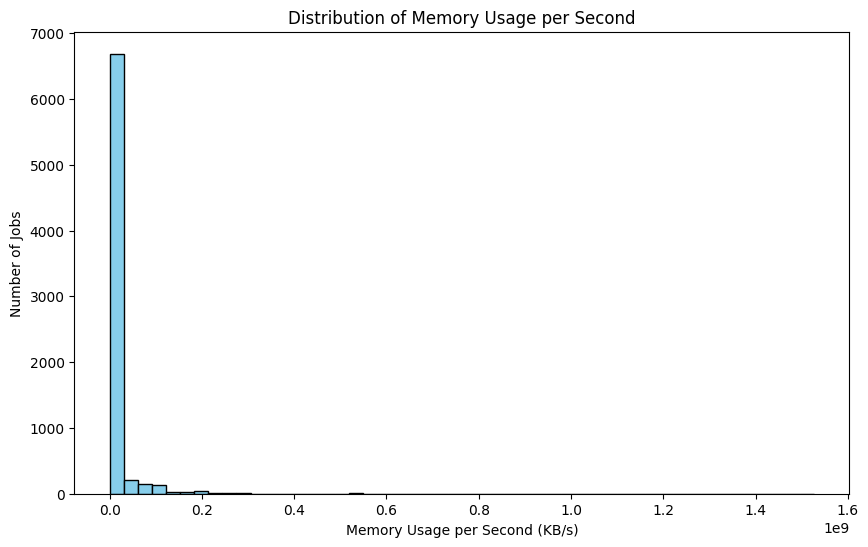

In [22]:
# Ensure 'timestamp' is a column (reset index if it's currently the index)
df_cleaned.reset_index(inplace=True)

# Calculate total memory usage and duration per job
job_efficiency = df_cleaned.groupby('jobid').agg({
    'value': ['mean', 'max', 'sum'],
    'timestamp': ['min', 'max']  # Ensure 'timestamp' is available for this operation
})

# Flatten column names
job_efficiency.columns = ['_'.join(col).strip() for col in job_efficiency.columns.values]

# Calculate job duration in seconds
job_efficiency['duration'] = (job_efficiency['timestamp_max'] - job_efficiency['timestamp_min']).dt.total_seconds()

# Handle jobs with zero duration
job_efficiency = job_efficiency[job_efficiency['duration'] > 0]

# Calculate efficiency metrics
job_efficiency['memory_per_second'] = job_efficiency['value_sum'] / job_efficiency['duration']
job_efficiency['memory_mean_per_second'] = job_efficiency['value_mean'] / job_efficiency['duration']

# Replace infinite and NaN values
job_efficiency.replace([np.inf, -np.inf], np.nan, inplace=True)
job_efficiency.dropna(subset=['memory_per_second'], inplace=True)

# Identify top 10 most efficient jobs (lowest memory per second)
most_efficient_jobs = job_efficiency.nsmallest(10, 'memory_per_second')
print("Most Efficient Jobs:")
print(most_efficient_jobs[['memory_per_second', 'duration']])

# Identify top 10 least efficient jobs (highest memory per second)
least_efficient_jobs = job_efficiency.nlargest(10, 'memory_per_second')
print("\nLeast Efficient Jobs:")
print(least_efficient_jobs[['memory_per_second', 'duration']])

# Plot efficiency distribution
plt.figure(figsize=(10, 6))
plt.hist(job_efficiency['memory_per_second'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Memory Usage per Second')
plt.xlabel('Memory Usage per Second (KB/s)')
plt.ylabel('Number of Jobs')
file_path = os.path.join(output_folder, 'dist_memory_usage_per_second.png')
plt.savefig(file_path, format='png')
plt.show()


*Explanation*: [EDIT]

* memory_per_second represents the total memory used divided by the total time the job ran.
* Jobs with lower memory_per_second values are considered more efficient.
The distribution plot helps visualize the overall efficiency of jobs.

# **Clustering into 9**

This code analyzes job data by grouping jobs based on their memory usage and duration, categorizing them into nine groups using quantile thresholds for average memory usage (high, medium, low) and duration (long, medium, short). It visualizes these categories through various plots to uncover trends and patterns. A faceted scatter plot maps duration against average memory usage, color-coded by category, revealing relationships between the two metrics. Box plots highlight the distribution of memory usage and duration across categories, showing central tendencies and outliers. A 3D scatter plot adds depth by visualizing the relationship between duration, memory usage, and category in a three-dimensional space. Finally, a Seaborn FacetGrid generates scatter plots for each category, allowing for detailed comparisons of category-specific trends. These visualizations collectively provide insights into job performance and resource efficiency, helping identify patterns or anomalies in memory usage and job durations.

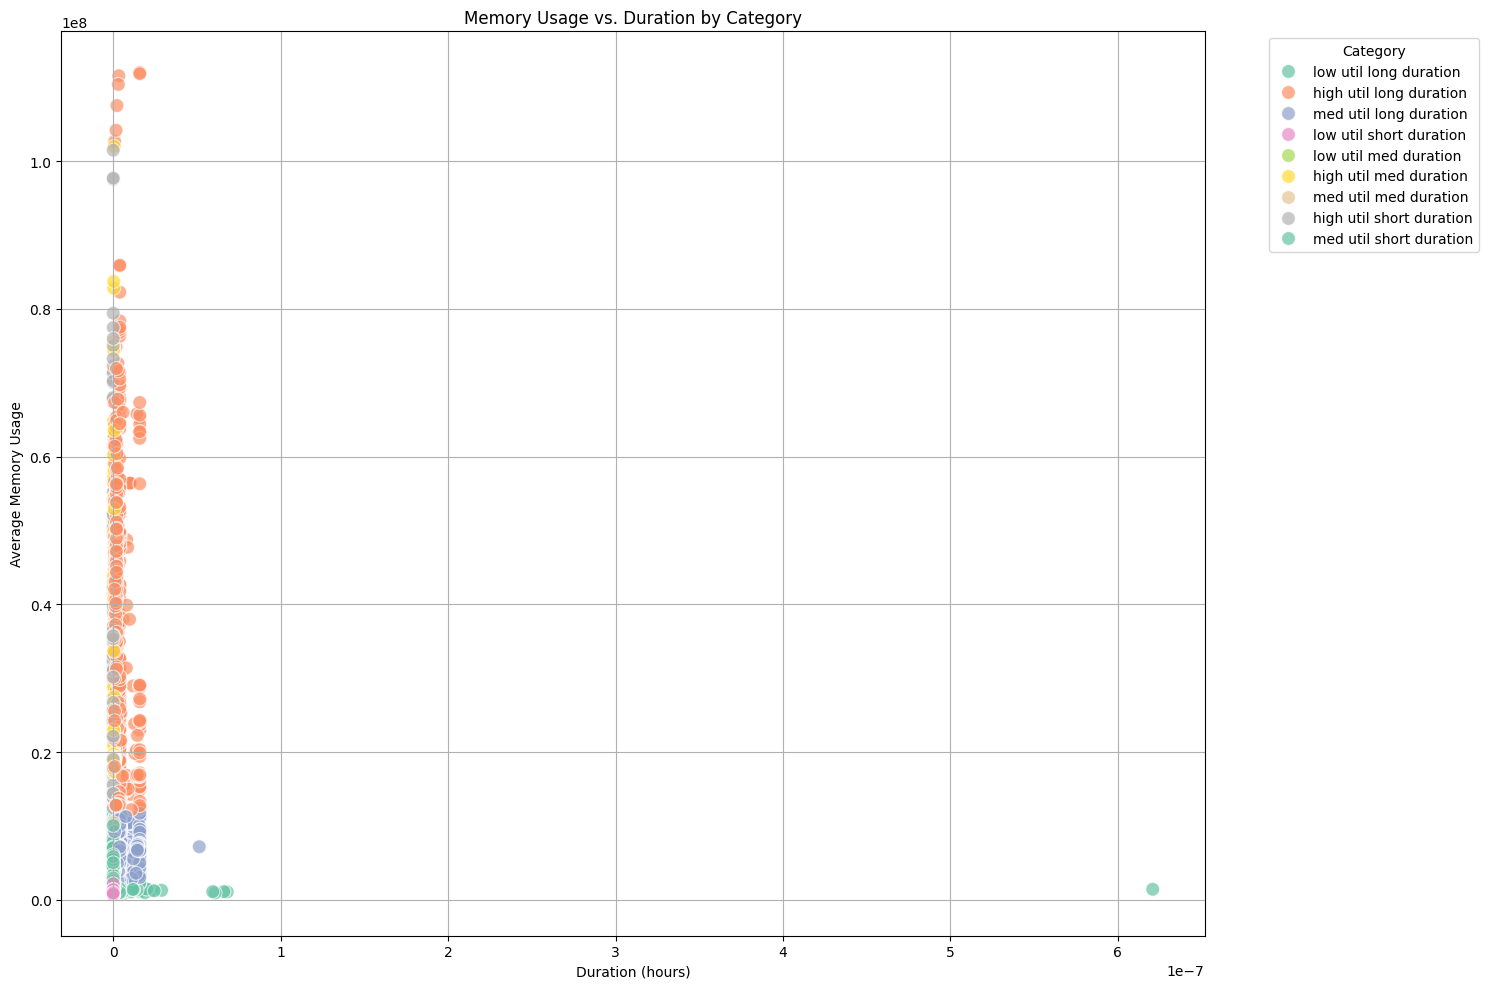

C:\Users\kruth\AppData\Local\Temp\ipykernel_30028\3116434755.py:56: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




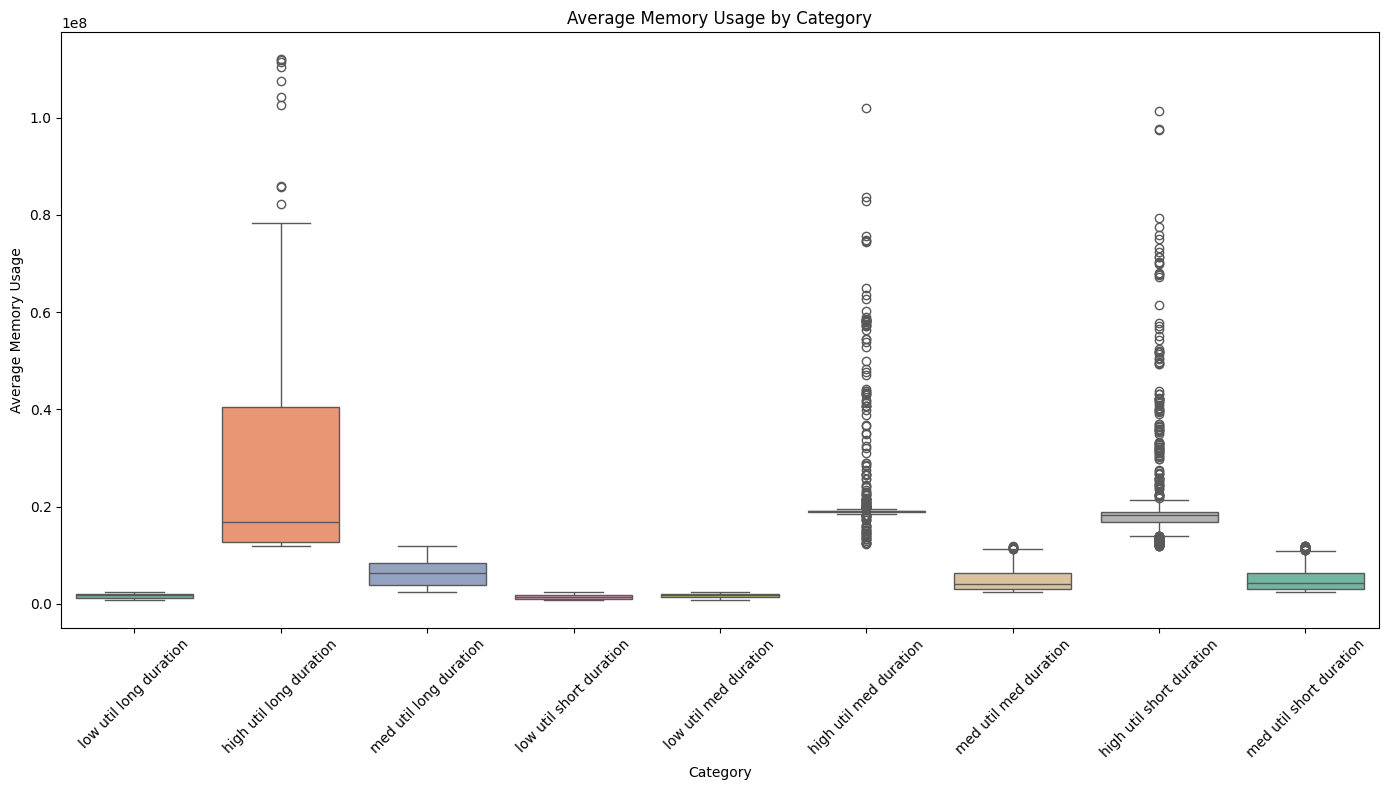

C:\Users\kruth\AppData\Local\Temp\ipykernel_30028\3116434755.py:66: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




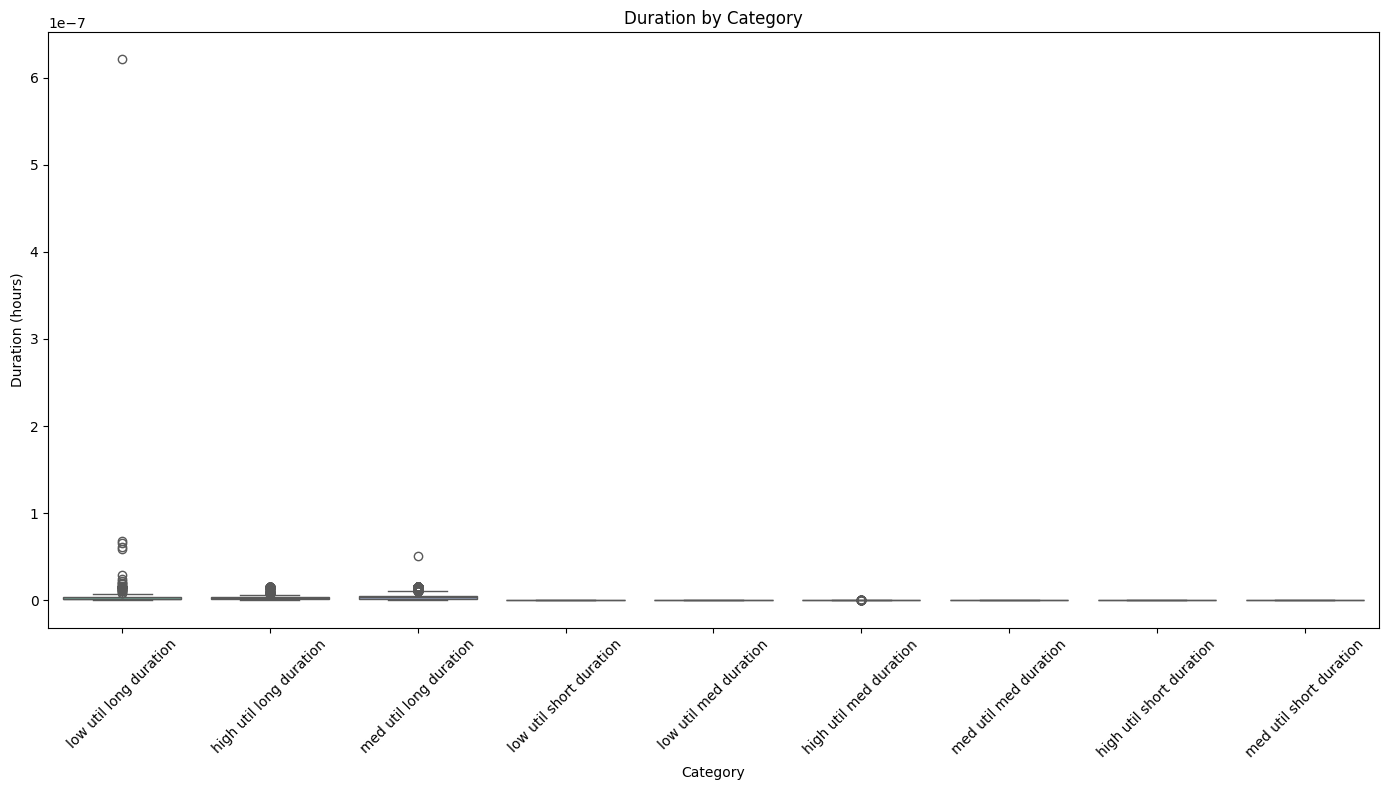

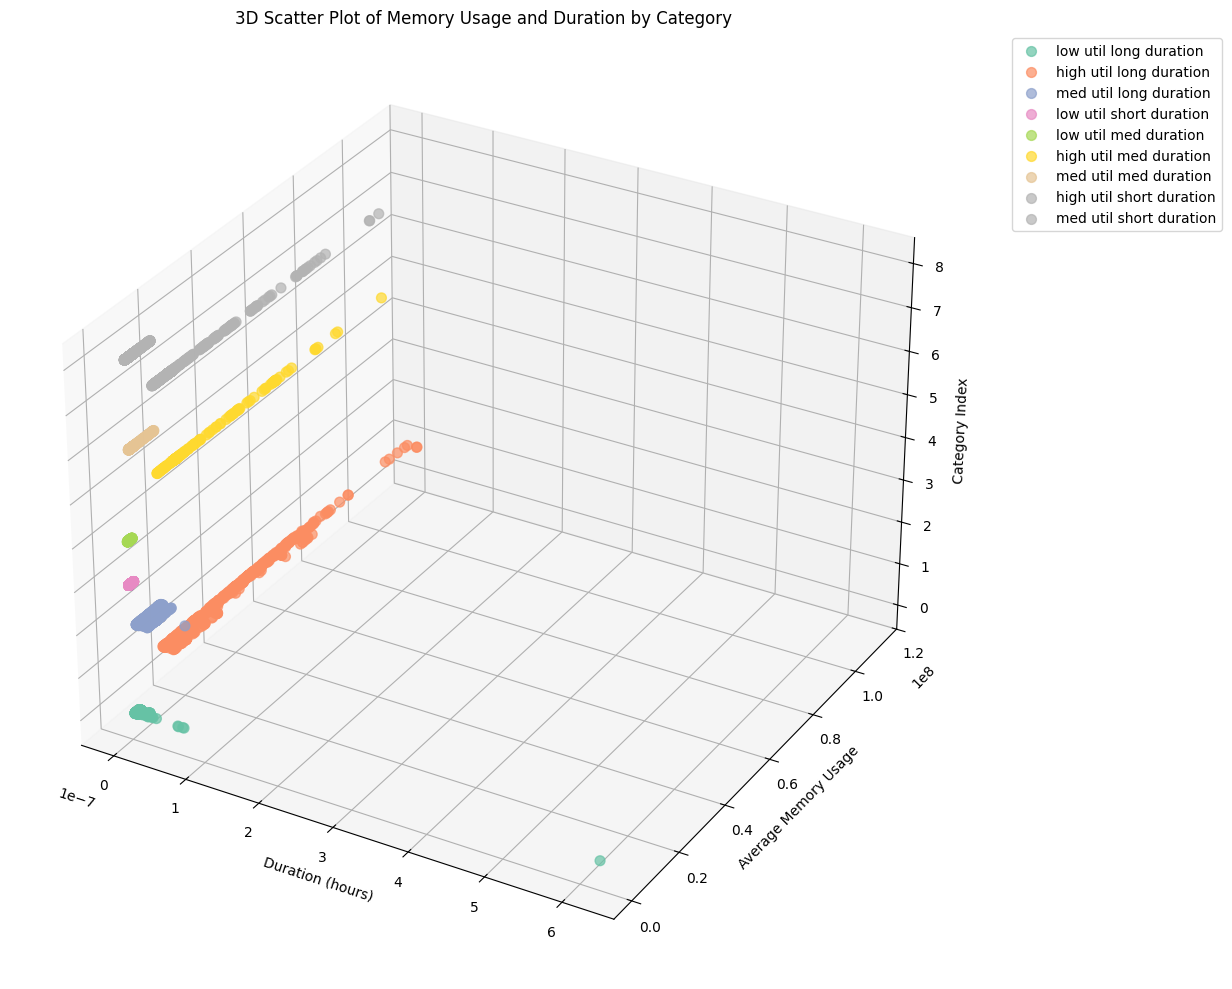

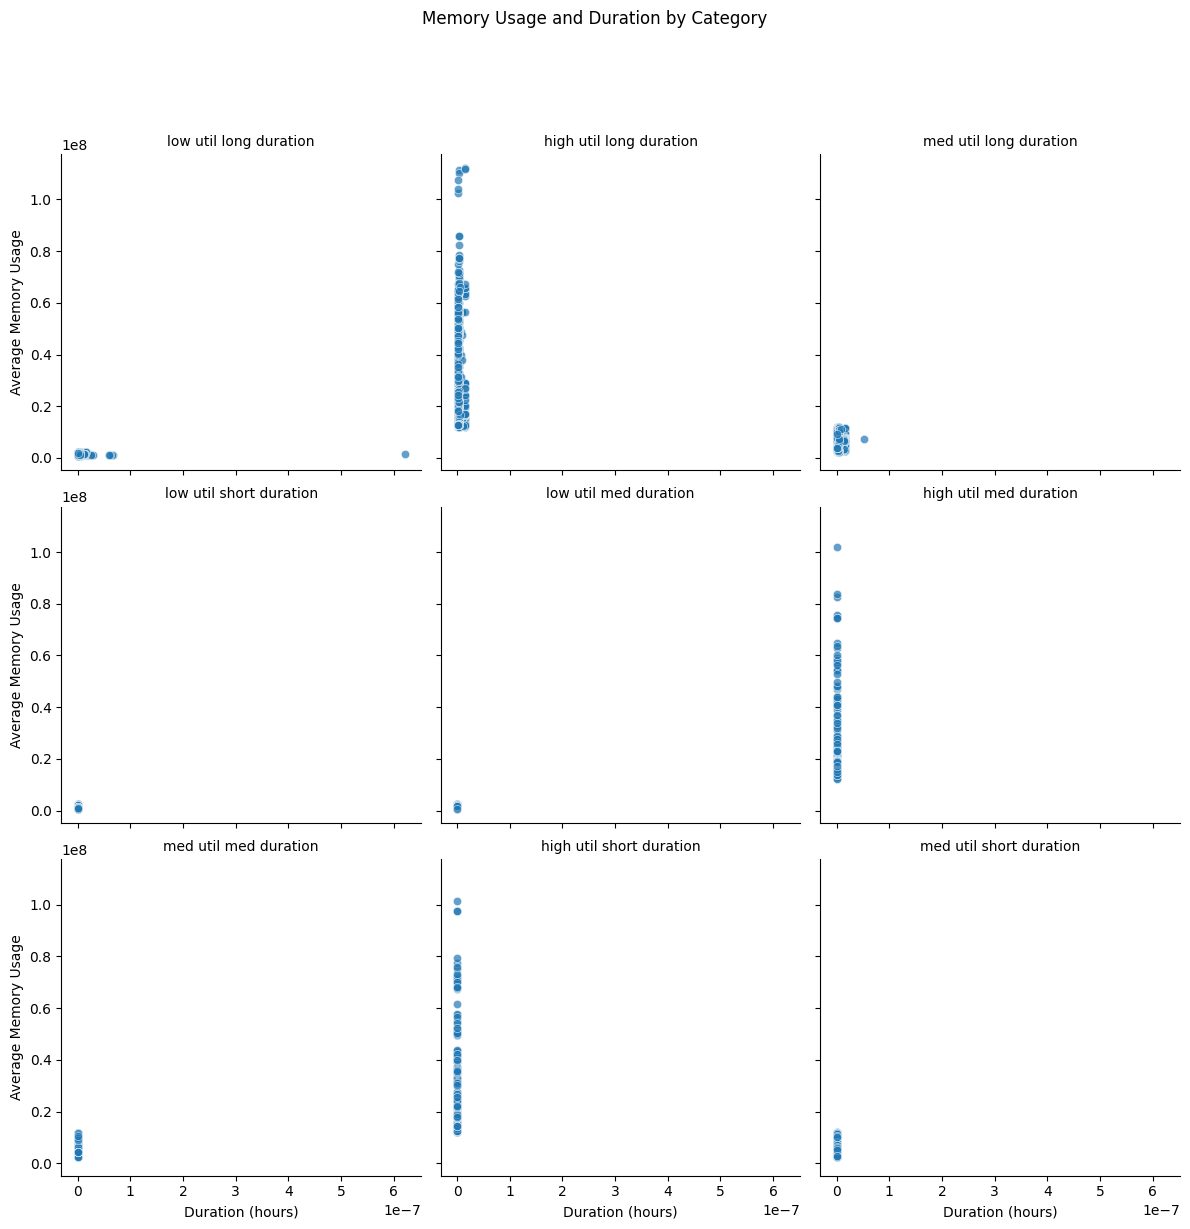

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')  # Handle invalid formats gracefully

# Check for invalid timestamps
if df['timestamp'].isnull().any():
    print("Warning: Some timestamps could not be converted to datetime format. Check your data.")

# Group by jobid to calculate duration and average memory usage for each job
job_stats = df.groupby('jobid').agg(
    duration=('timestamp', lambda x: (x.max() - x.min()).total_seconds() / 3600 if len(x) > 1 else 0),  # Convert to hours
    avg_memory_usage=('value', 'mean')
).reset_index()

# Define thresholds for memory utilization and duration
high_util_threshold = job_stats['avg_memory_usage'].quantile(0.67)
low_util_threshold = job_stats['avg_memory_usage'].quantile(0.33)
long_duration_threshold = job_stats['duration'].quantile(0.67)
short_duration_threshold = job_stats['duration'].quantile(0.33)

# Function to categorize jobs
def categorize_job(row):
    util = (
        'high' if row['avg_memory_usage'] >= high_util_threshold else
        'low' if row['avg_memory_usage'] <= low_util_threshold else
        'med'
    )
    duration = (
        'long' if row['duration'] >= long_duration_threshold else
        'short' if row['duration'] <= short_duration_threshold else
        'med'
    )
    return f"{util} util {duration} duration"

# Apply categorization function to each job
job_stats['category'] = job_stats.apply(categorize_job, axis=1)

# Option 1: Faceted Scatter Plot with Colors by Category
plt.figure(figsize=(15, 10))
sns.scatterplot(data=job_stats, x='duration', y='avg_memory_usage', hue='category', palette='Set2', s=100, alpha=0.7)
plt.title('Memory Usage vs. Duration by Category')
plt.xlabel('Duration (hours)')
plt.ylabel('Average Memory Usage')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Option 2: Box Plots by Category
# Box plot for memory usage by category
plt.figure(figsize=(14, 8))
sns.boxplot(data=job_stats, x='category', y='avg_memory_usage', palette='Set2')
plt.title('Average Memory Usage by Category')
plt.xlabel('Category')
plt.ylabel('Average Memory Usage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plot for duration by category
plt.figure(figsize=(14, 8))
sns.boxplot(data=job_stats, x='category', y='duration', palette='Set2')
plt.title('Duration by Category')
plt.xlabel('Category')
plt.ylabel('Duration (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Option 3: 3D Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
categories = job_stats['category'].unique()
colors = plt.cm.Set2(range(len(categories)))
category_color_map = dict(zip(categories, colors))
for category, color in category_color_map.items():
    category_data = job_stats[job_stats['category'] == category]
    ax.scatter(
        category_data['duration'],
        category_data['avg_memory_usage'],
        zs=list(categories).index(category),
        color=color,
        label=category,
        s=50,
        alpha=0.7
    )
ax.set_xlabel('Duration (hours)')
ax.set_ylabel('Average Memory Usage')
ax.set_zlabel('Category Index')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('3D Scatter Plot of Memory Usage and Duration by Category')
plt.tight_layout()
plt.show()

# Option 4: Seaborn FacetGrid
g = sns.FacetGrid(job_stats, col="category", col_wrap=3, height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x='duration', y='avg_memory_usage', alpha=0.7)
g.set_axis_labels("Duration (hours)", "Average Memory Usage")
g.set_titles("{col_name}")
g.fig.suptitle("Memory Usage and Duration by Category", y=1.02)
g.fig.subplots_adjust(top=0.9)  # Adjust to provide more room for the title
plt.show()


## **Conclusion** [EDIT]


* Detected Anomalies: Identified unusual memory usage patterns that may indicate issues or opportunities for optimization.
* Clustered Jobs: Grouped jobs with similar resource usage, aiding in understanding workload patterns.
* Predicted Resource Usage: Built models to forecast future memory usage, useful for capacity planning.
* Analyzed Job Efficiency: Assessed resource utilization efficiency, highlighting jobs that may need optimization.

## **Performance Optimization Insights**

### 1. Resource Bottleneck Identification

**Objective**: Identify jobs or processes that consume excessive resources, focusing on memory usage since it's the metric available in your dataset.

Approach:
* Per Job Analysis:
Calculate total and average memory usage per job.
Identify jobs with memory usage significantly higher than the average.
* Per Host Analysis:
Calculate total and average memory usage per host.
Identify hosts that are under heavy load due to high memory consumption.

Jobs Consuming Excessive Memory Resources:
         jobid  avg_memory_usage  max_memory_usage  total_memory_usage  \
5010  15025738      1.119872e+08       116435056.0        2.686842e+13   
5529  15026331      1.118155e+08       116642000.0        2.673452e+13   
135   15019913      1.115384e+08       126894696.0        7.100979e+12   
2122  15022432      1.103657e+08       122119464.0        7.184809e+10   
4177  15024808      1.075079e+08       122490288.0        5.622663e+10   
...        ...               ...               ...                 ...   
1577  15021680      3.589776e+07        51908732.0        7.394939e+09   
6816  15027663      3.586312e+07        70275840.0        2.151787e+08   
7239  15028118      3.570996e+07        43875520.0        8.748940e+09   
2436  15022829      3.564131e+07        42652552.0        1.318372e+11   
607   15020559      3.560417e+07        62226464.0        3.168771e+09   

      num_records  
5010       239924  
5529       239095  
135     

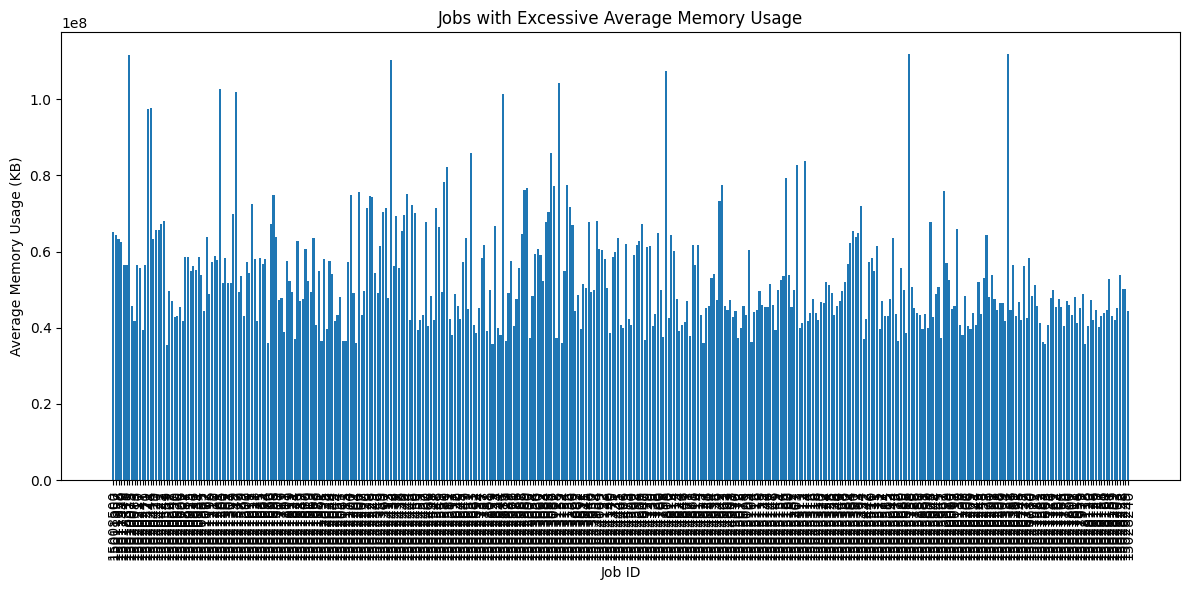

Threshold at 95th Percentile: 20557963.527863894
        host  avg_memory_usage  max_memory_usage  total_memory_usage  \
11    gr0012      2.149547e+07       112963400.0        1.891666e+12   
261   gr0262      2.370480e+07        94847744.0        2.067106e+12   
291   gr0292      2.083246e+07       111853744.0        1.813966e+12   
677   gr0678      2.089193e+07       104735360.0        1.724712e+12   
683   gr0684      2.065038e+07       105027864.0        1.757223e+12   
...      ...               ...               ...                 ...   
1260  gr1261      2.470163e+07       112141232.0        2.080816e+12   
1261  gr1262      2.437339e+07       112446000.0        2.058284e+12   
1262  gr1263      2.450661e+07       113105616.0        2.068260e+12   
1263  gr1264      2.476880e+07       112138224.0        2.090164e+12   
1264  gr1265      2.294316e+07       112347824.0        1.896092e+12   

      num_records  
11          88003  
261         87202  
291         87074  
677   

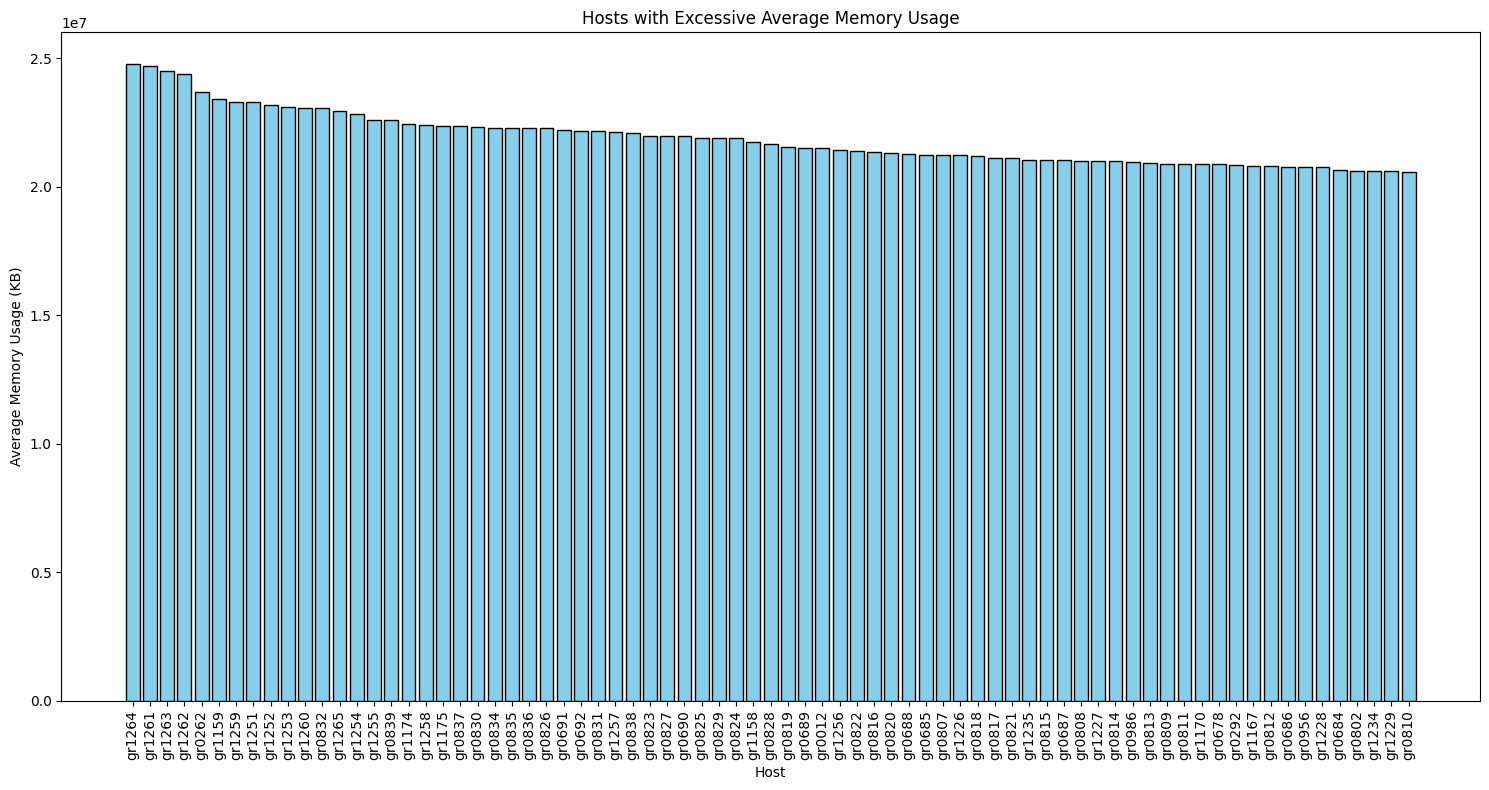

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_cleaned is your DataFrame with 'host', 'jobid', 'timestamp', and 'value' columns.
# Convert 'timestamp' to datetime if not already
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Calculate total and average memory usage per job
job_usage = df_cleaned.groupby('jobid')['value'].agg(['mean', 'max', 'sum', 'count']).reset_index()
job_usage.rename(columns={'mean': 'avg_memory_usage', 'max': 'max_memory_usage', 'sum': 'total_memory_usage', 'count': 'num_records'}, inplace=True)

# Calculate overall average memory usage
overall_avg_memory = job_usage['avg_memory_usage'].mean()

# Identify jobs consuming excessive resources (e.g., jobs with avg_memory_usage > overall average by a significant margin)
threshold_multiplier = 3.5
memory_usage_threshold = overall_avg_memory * threshold_multiplier

resource_intensive_jobs = job_usage[job_usage['avg_memory_usage'] > memory_usage_threshold]

print("Jobs Consuming Excessive Memory Resources:")
print(resource_intensive_jobs.sort_values(by='avg_memory_usage', ascending=False))

# Plotting the top resource-intensive jobs
plt.figure(figsize=(12,6))
plt.bar(resource_intensive_jobs['jobid'].astype(str), resource_intensive_jobs['avg_memory_usage'])
plt.title('Jobs with Excessive Average Memory Usage')
plt.xlabel('Job ID')
plt.ylabel('Average Memory Usage (KB)')
plt.xticks(rotation=90)
plt.tight_layout()
file_path = os.path.join(output_folder, 'jobs_excessive_avg_memory_usage.png')
plt.savefig(file_path, format='png')
plt.show()

# Similarly, analyze memory usage per host
# Calculate memory usage statistics per host
host_usage = df_cleaned.groupby('host')['value'].agg(['mean', 'max', 'sum', 'count']).reset_index()
host_usage.rename(columns={'mean': 'avg_memory_usage', 'max': 'max_memory_usage', 'sum': 'total_memory_usage', 'count': 'num_records'}, inplace=True)

# Calculate overall average memory usage per host
overall_avg_memory_host = host_usage['avg_memory_usage'].mean()

# # Identify hosts under heavy load
# threshold_multiplier = 3  # Adjust based on the desired threshold
# host_memory_usage_threshold = overall_avg_memory_host * threshold_multiplier
# heavy_load_hosts = host_usage[host_usage['avg_memory_usage'] > host_memory_usage_threshold]

upper_percentile = 95
threshold_percentile = np.percentile(host_usage['avg_memory_usage'], upper_percentile)
heavy_load_hosts = host_usage[host_usage['avg_memory_usage'] > threshold_percentile]

print(f"Threshold at {upper_percentile}th Percentile:", threshold_percentile)
print(heavy_load_hosts)


top_heavy_load_hosts = heavy_load_hosts.sort_values(by='avg_memory_usage', ascending=False)

print("Hosts Under Heavy Memory Load:")
print(heavy_load_hosts[['host', 'avg_memory_usage', 'max_memory_usage', 'total_memory_usage']])

# Plotting the top 55 hosts
plt.figure(figsize=(15, 8))
plt.bar(top_heavy_load_hosts['host'], top_heavy_load_hosts['avg_memory_usage'], color='skyblue', edgecolor='black')
plt.title('Hosts with Excessive Average Memory Usage')
plt.xlabel('Host')
plt.ylabel('Average Memory Usage (KB)')
plt.xticks(rotation=90)
plt.tight_layout()
file_path = os.path.join(output_folder, 'hosts_excessive_avg_memory_usage.png')
plt.savefig(file_path, format='png')
plt.show()

**Interpretation:** [EDIT]

* Resource-Intensive Jobs:
  * Jobs listed in resource_intensive_jobs are consuming significantly more memory than the average job.
  * These jobs may need optimization or special scheduling considerations.
* Heavy Load Hosts:
  * Hosts listed in heavy_load_hosts are under heavier memory load compared to others.
  * Investigate if these hosts are being assigned disproportionately heavy jobs or if there's an imbalance in resource allocation.

### 2. Optimization Recommendations

**Objective**: Suggest improvements for job scheduling and resource allocation based on the identified bottlenecks.

Approach:
* Analyze Job Patterns:
Examine the characteristics of resource-intensive jobs (e.g., job duration, frequency).
* Scheduling Strategies:
Propose scheduling adjustments to distribute high-memory jobs more evenly over time and across hosts.
* Resource Allocation:
Suggest allocating additional resources to heavily loaded hosts or redistributing workloads.

In [25]:
# Merge resource-intensive jobs with the original data to analyze further
resource_jobs_data = df_cleaned[df_cleaned['jobid'].isin(resource_intensive_jobs['jobid'])]

# Calculate job durations
job_durations = resource_jobs_data.groupby('jobid').agg({
    'timestamp': ['min', 'max']
}).reset_index()
job_durations.columns = ['jobid', 'start_time', 'end_time']
job_durations['duration_seconds'] = (job_durations['end_time'] - job_durations['start_time']).dt.total_seconds()

# Merge duration back into resource-intensive jobs dataframe
resource_intensive_jobs = resource_intensive_jobs.merge(job_durations[['jobid', 'duration_seconds']], on='jobid')

print("Resource-Intensive Jobs with Duration:")
print(resource_intensive_jobs.sort_values(by='avg_memory_usage', ascending=False))


Resource-Intensive Jobs with Duration:
        jobid  avg_memory_usage  max_memory_usage  total_memory_usage  \
298  15025738      1.119872e+08       116435056.0        2.686842e+13   
335  15026331      1.118155e+08       116642000.0        2.673452e+13   
6    15019913      1.115384e+08       126894696.0        7.100979e+12   
104  15022432      1.103657e+08       122119464.0        7.184809e+10   
207  15024808      1.075079e+08       122490288.0        5.622663e+10   
..        ...               ...               ...                 ...   
58   15021680      3.589776e+07        51908732.0        7.394939e+09   
349  15027663      3.586312e+07        70275840.0        2.151787e+08   
364  15028118      3.570996e+07        43875520.0        8.748940e+09   
142  15022829      3.564131e+07        42652552.0        1.318372e+11   
20   15020559      3.560417e+07        62226464.0        3.168771e+09   

     num_records  duration_seconds  
298       239924           57620.0  
335       

**Recommendations Based on Findings:** [EDIT]

* Redistribute High-Memory Jobs:
If resource-intensive jobs are scheduled at the same time, consider staggering their execution to reduce peak memory load.
* Optimize Job Performance:
Investigate if high-memory jobs can be optimized in code to use memory more efficiently.
* Resource Allocation Policies:
Implement policies to limit the maximum memory usage per job or allocate more resources to jobs that require them.
* Host Allocation:
Assign high-memory jobs to hosts with more available memory or balance the load by distributing such jobs across multiple hosts.

Example Recommendation:

Suppose you find that certain jobs consistently consume high memory and run during peak hours. You might recommend:

* Scheduling these jobs during off-peak hours to reduce the impact on overall system performance.
* Breaking down large jobs into smaller tasks if possible, to reduce memory consumption.
* Implementing memory usage limits within the job's execution environment.


### 3. Load Balancing Analysis

**Objective**: Evaluate how evenly the workload is distributed across the cluster.

Approach:
* Assess Memory Usage Across Hosts Over Time:
Analyze memory usage per host over time to see if some hosts are consistently more loaded.
* Visualize Load Distribution:
Use heatmaps or line charts to visualize memory usage across hosts.
* Statistical Analysis:
Calculate variance and standard deviation of memory usage across hosts.

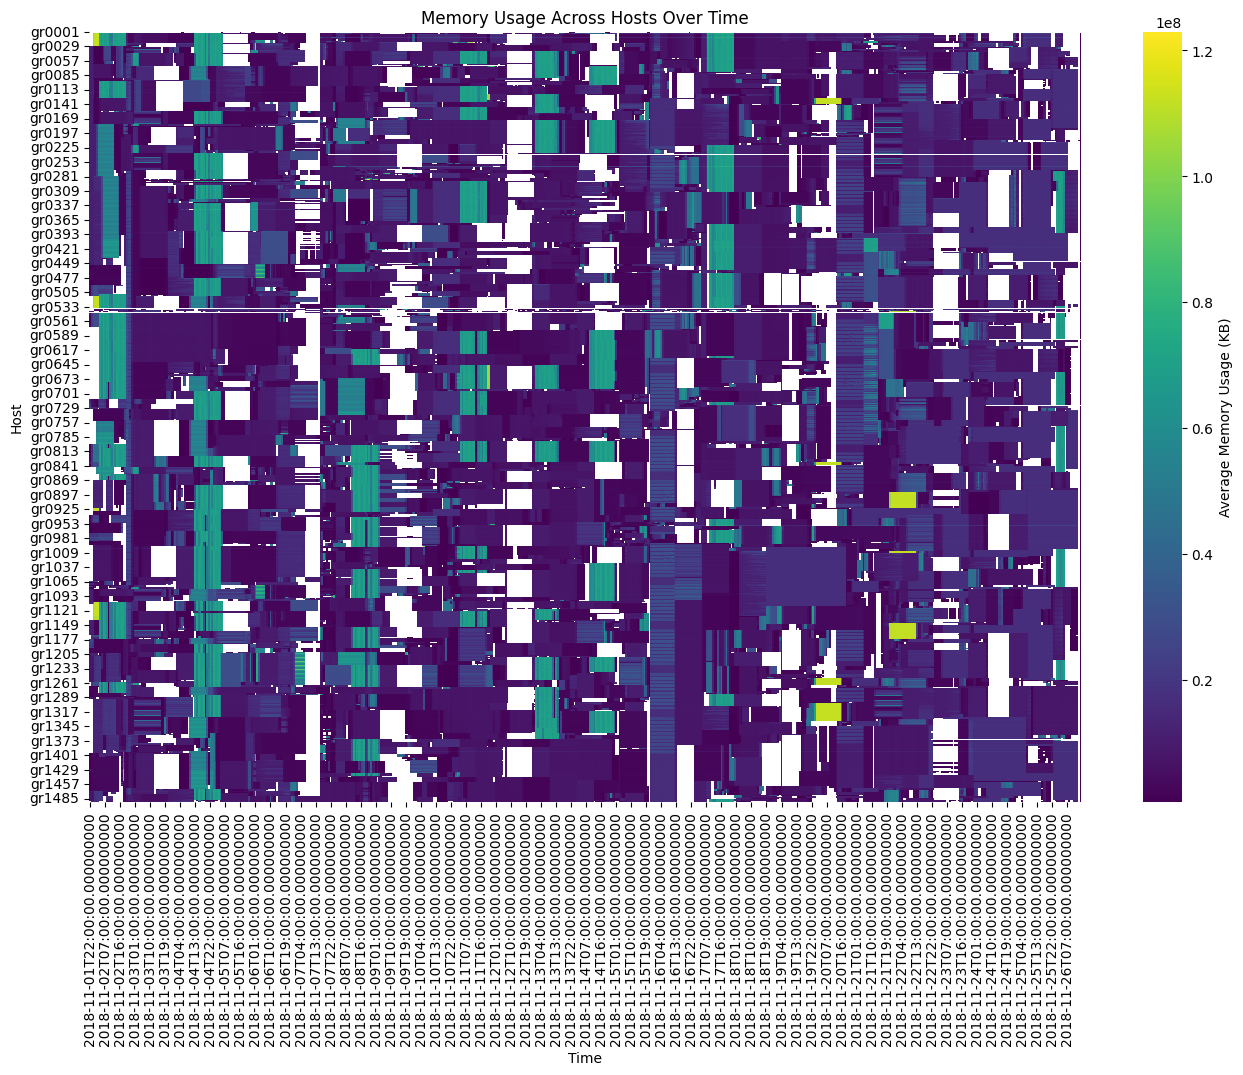

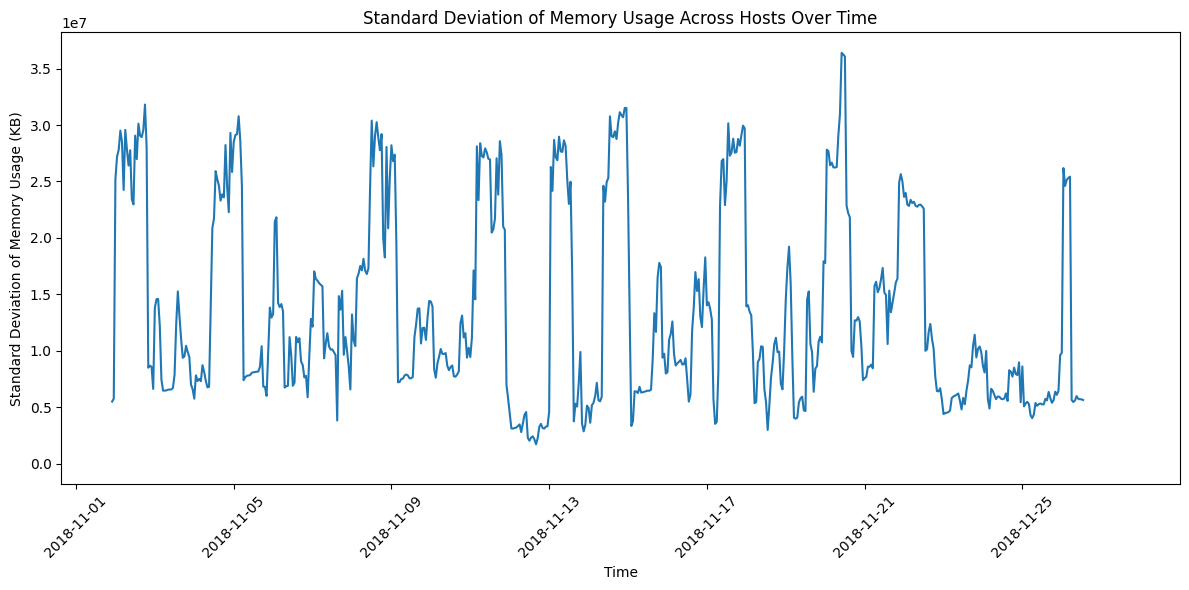

Overall Memory Usage per Host:
host
gr0001    2.202479e+06
gr0002    1.836754e+06
gr0003    1.255712e+07
gr0004    2.014954e+07
gr0005    1.494825e+07
              ...     
gr1486    1.421243e+07
gr1487    1.229390e+07
gr1488    1.170015e+07
gr1489    1.331801e+07
gr1490    1.259148e+07
Name: value, Length: 1490, dtype: float64
Coefficient of Variation across Hosts: 0.1752


In [26]:
import seaborn as sns

# Aggregate memory usage per host over time (e.g., hourly)
df_cleaned.set_index('timestamp', inplace=True)
host_time_usage = df_cleaned.groupby([pd.Grouper(freq='H'), 'host'])['value'].mean().reset_index()

# Pivot the data to have hosts as columns and time as rows
host_time_pivot = host_time_usage.pivot(index='timestamp', columns='host', values='value')

# Plot heatmap to visualize load distribution across hosts over time
plt.figure(figsize=(16,10))
sns.heatmap(host_time_pivot.T, cmap='viridis', cbar_kws={'label': 'Average Memory Usage (KB)'})
plt.title('Memory Usage Across Hosts Over Time')
plt.xlabel('Time')
plt.ylabel('Host')
file_path = os.path.join(output_folder, 'memory_usage_hosts_time.png')
plt.savefig(file_path, format='png')
plt.show()

# Calculate variance and standard deviation of memory usage across hosts
host_variance = host_time_pivot.var(axis=1)
host_std_dev = host_time_pivot.std(axis=1)

# Plot standard deviation over time
plt.figure(figsize=(12,6))
plt.plot(host_std_dev.index, host_std_dev.values)
plt.title('Standard Deviation of Memory Usage Across Hosts Over Time')
plt.xlabel('Time')
plt.ylabel('Standard Deviation of Memory Usage (KB)')
plt.xticks(rotation=45)
plt.tight_layout()
file_path = os.path.join(output_folder, 'std_dev_memory_usage_hosts_time.png')
plt.savefig(file_path, format='png')
plt.show()

# Calculate overall load distribution statistics
overall_host_usage = df_cleaned.groupby('host')['value'].mean()
print("Overall Memory Usage per Host:")
print(overall_host_usage)

# Calculate coefficient of variation (CV) across hosts
cv_hosts = overall_host_usage.std() / overall_host_usage.mean()
print(f"Coefficient of Variation across Hosts: {cv_hosts:.4f}")


**Interpretation:** [EDIT]

* Load Imbalance Detection:
High variance and standard deviation suggest uneven workload distribution.
A high CV indicates significant variability in host memory usage.
* Recommendations for Load Balancing:
Implement load balancing strategies to distribute workloads more evenly.
Consider using a scheduler that takes current host load into account when assigning jobs.

## **Recommendations** [EDIT]

Based on the analyses:

* **Resource Bottlenecks:**

  * Identified specific jobs (resource_intensive_jobs) and hosts (heavy_load_hosts) consuming excessive memory.
  * These jobs and hosts are candidates for optimization efforts.

* **Optimization Recommendations:**

  * Job-Level Optimization:
  Optimize code of resource-intensive jobs to improve memory efficiency.
  Schedule high-memory jobs during off-peak hours or distribute them over time.
  * Host-Level Optimization:
  Balance the job assignments across hosts to prevent overloading specific nodes.
  Consider upgrading hardware or increasing resources on heavily loaded hosts.

* **Load Balancing Analysis:**

  * Detected load imbalance across hosts, with some hosts bearing more memory load than others.
  * Suggested implementing a dynamic scheduling system that considers real-time host load.